# Orçamento de Estado de 2021

A análise das votações e posicionamento relativo dos partidos tendo como base *exclusivamente* a forma como votam foi a base do trabalho anterior, análise essa que teve como fonte as votações das Iniciativas e Actividades.

O Orçamento de Estado para 2021 foi um acontecimento marcante da realidade política nacional do último trimestre de 2020 e que continuará a ter impactos na apreciação e debate político no futuro próximo: a posição dos vários partidos em termos de viabilização ou não do OE, as propostas que apresentaram e quem as aprovou ou recusou são matéria utilizada no debate para as Presidenciais, por exemplo.

## Metodologia

Com base nos dados disponibilizados pela Assembleia da República em formato XML são criadas _dataframes_ (tabelas de duas dimensões) com base na selecção de informação relativa aos padrões de votação de cada partido (e/ou deputados não-inscritos)

São fundamentalmente feitas as seguintes análises:

1. Quantidade e tipo de propostas feitas, e resultado das mesmas
2. Apoio para as propostas de cada partido
2. Matriz de distância entre todos os partidos e dendograma
3. Identificação de grupos (_spectral clustering_) e visualização das distâncias num espaço cartesiano (_multidimensional scaling_)

In [1]:
!pip3 install --user -q  matplotlib pandas seaborn sklearn 

%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sklearn.cluster import SpectralClustering
from sklearn.manifold import MDS
import random
import seaborn as sns
from matplotlib.colors import ListedColormap
sns.set_theme(style="whitegrid", palette="pastel")

In [3]:
from urllib.request import urlopen
import xml.etree.ElementTree as ET

oe_url = "http://app.parlamento.pt/webutils/docs/doc.xml?path=6148523063446f764c324679626d56304c3239775a57356b595852684c3052685a47397a51574a6c636e52766379395063734f6e5957316c626e52764a5449775a47386c4d6a4246633352685a47387657456c574a5449775447566e61584e7359585231636d457654305651636d397762334e3059584e426248526c636d466a595738794d4449785433497565473173&fich=OEPropostasAlteracao2021Or.xml&Inline=true"
#oe_tree = ET.parse(urlopen(oe_url))
oe_file = './OEPropostasAlteracao2021Or.xml'
oe_tree = ET.parse(oe_file)

In [4]:
import collections

counter=0
vc=0
## We will build a dataframe from a list of dicts
## Inspired by the approach of Chris Moffitt here https://pbpython.com/pandas-list-dict.html
oe_list = []

for alter in oe_tree.findall(".//PropostaDeAlteracao"):
    votep = alter.find('./Votacoes')
    if votep is not None:
        oe_dict = collections.OrderedDict()
        counter +=1
        oe_dict["ID"]=alter.find('./ID').text
        oe_dict["Nr"]=alter.find('./Numero').text
        oe_dict["Date"]=alter.find('./Data').text
        oe_dict["Domain"]=alter.find('./Tema').text
        oe_dict["Type"]=alter.find('./Tipo').text
        oe_dict["State"]=alter.find('./Estado').text
        oe_dict["GP"]=alter.find('./GrupoParlamentar_Partido').text
        init_title=alter.find('./Iniciativas_Artigos/Iniciativa_Artigo/Titulo')
        if init_title is not None:
            oe_dict["IniTitle"]=init_title.text
        #oe_list.append(oe_dict)
        for vote in alter.findall("./Votacoes/"):
            vc +=1
            for vote_el in vote:
                if vote_el.tag == "Data":
                    oe_dict["V_Date"] = vote_el.text
                    # print(oe_dict["ID"])
                if vote_el.tag == "Descricoes":
                    descp = vote_el.find('./Descricao')
                    if descp is not None: 
                        oe_dict["VoteDesc"] = vote_el.find('./Descricao').text
                if vote_el.tag == "Resultado":
                    oe_dict["Result"] = vote_el.text
                for gps in vote.findall("./GruposParlamentares/"):
                    if gps.tag == "GrupoParlamentar":
                        gp = gps.text
                    else:
                        oe_dict[gp] = gps.text

        oe_list.append(oe_dict)
    print('.', end='')
        
print("\nProposals:",counter)
print(vc)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [5]:
import pandas as pd

oe_df = pd.DataFrame(oe_list)
oe_df

ID     Nr                 Date  \
0     14658  1440C  13/11/2020 20:08:00   
1     14656  1439C  13/11/2020 19:59:00   
2     14655  1438C  13/11/2020 19:59:00   
3     14654  1437C  13/11/2020 19:59:00   
4     14653  1436C  13/11/2020 19:58:00   
...     ...    ...                  ...   
1542  13152     5C  29/10/2020 09:02:00   
1543  13151     4C  29/10/2020 09:02:00   
1544  13150     3C  29/10/2020 09:01:00   
1545  13149     2C  29/10/2020 09:01:00   
1546  13148     1C  29/10/2020 09:01:00   

                                                 Domain  \
0                                  Orçamento e Finanças   
1                                 Cultura e Comunicação   
2               Educação, Ciência, Juventude e Desporto   
3                                  Orçamento e Finanças   
4       Negócios Estrangeiros e Comunidades Portuguesas   
...                                                 ...   
1542                       Centro de recolha de animais   
1543      Ambiente, Energia e Ordenamento do Território   
1544                                            Creches   
1545  Administração Pública, Modernização Administra...   
1546                        Trabalho e Segurança Social   

                                Type                                 State  \
0     Aditamento (Números e Alíneas)               Aprovado(a) em Comissão   
1                        Por Definir                           Retirado(a)   
2            Aditamento (Artigo PPL)  Aprovado(a) Parcialmente em Comissão   
3            Aditamento (Artigo PPL)              Rejeitado(a) em Comissão   
4            Aditamento (Artigo PPL)              Rejeitado(a) em Comissão   
...                              ...                                   ...   
1542                          Emenda              Rejeitado(a) em Comissão   
1543         Aditamento (Artigo PPL)               Aprovado(a) em Comissão   
1544  Aditamento (Números e Alíneas)              Rejeitado(a) em Comissão   
1545                    Substituição               Aprovado(a) em Comissão   
1546  Aditamento (Números e Alíneas)               Aprovado(a) em Comissão   

                      GP                                           IniTitle  \
0                     PS  Investimento em infraestruturas de habitação p...   
1                    PCP                                                NaN   
2                    PCP  Programa de apoio ao trabalho artístico e cult...   
3                    PCP  Devolução de verbas do Fundo de Garantia Autom...   
4                    PCP    Apoio às associações portuguesas no estrangeiro   
...                  ...                                                ...   
1542  CRISTINA RODRIGUES  Centros de recolha oficial de animais, apoio à...   
1543                 PEV  Avaliação ambiental estratégica para aferir me...   
1544                 PCP                             Gratuitidade de creche   
1545                 PCP  Reforço de dotação do pessoal não docente na e...   
1546                 PCP  Subsídio extraordinário de risco no combate à ...   

                 VoteDesc Partido Socialista  ... Pessoas-Animais-Natureza  \
0     N.º 3, Artigo 150.º              Favor  ...                    Favor   
1                     NaN                NaN  ...                      NaN   
2          Artigo 171.º-A              Favor  ...                    Favor   
3          Artigo 207.º-A             Contra  ...                   Contra   
4           Artigo 30.º-A             Contra  ...                    Favor   
...                   ...                ...  ...                      ...   
1542  N.º 1, Artigo 211.º             Contra  ...                    Favor   
1543       Artigo 196.º-A             Contra  ...                    Favor   
1544  N.º 7, Artigo 114.º             Contra  ...                    Favor   
1545         Artigo 174.º              Favor  ...                    Favor   
1546  N.º 4, Artigo 185.º              

## As propostas: quantidade, aprovações, rejeições

Após obtermos e processarmos o ficheiro com as Propostas de Alteração podemos ter uma primeira ideia sobre a origem das propostas:

```{margin}
Em gráfico de barras:
```

In [6]:
oe_df.groupby('GP')[['ID']].count().sort_values(by=['ID'], axis=0, ascending=False).plot(kind="bar",stacked=True,figsize=(6,6))
plt.show()


In [7]:
oe_df.groupby('GP')[['ID']].count().sort_values("ID", ascending=False)

ID
GP                                                     
PCP                                                 352
PAN                                                 266
CH                                                  157
PEV                                                 123
IL                                                  115
CDS-PP                                              114
PSD                                                 104
CRISTINA RODRIGUES                                  101
PS                                                   79
PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   64
JOACINE KATAR MOREIRA                                60
BE                                                   12

```{margin}
«Os partidos que viabilizaram o OE 2021, sem contar com o PS, entregaram 58% das propostas de alteração, com um total de 898 medidas. O PCP, que é decisivo na votação final, é o que mais quer mudar OE», {cite}`eco58PropostasPara2020`)
```

In [8]:
pd.crosstab(oe_df.GP, oe_df.State)

State                                               Aguarda Voto em Comissão  \
GP                                                                             
BE                                                                         0   
CDS-PP                                                                     0   
CH                                                                         0   
CRISTINA RODRIGUES                                                         1   
IL                                                                         0   
JOACINE KATAR MOREIRA                                                      0   
PAN                                                                        0   
PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES                         0   
PCP                                                                        1   
PEV                                                                        0   
PS                                                                         0   
PSD                                                                        1   

State                                               Aprovado(a) Parcialmente em Comissão  \
GP                                                                                         
BE                                                                                     0   
CDS-PP                                                                                 1   
CH                                                                                     0   
CRISTINA RODRIGUES                                                                     1   
IL                                                                                     0   
JOACINE KATAR MOREIRA                                                                  0   
PAN                                                                                    5   
PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES                                     0   
PCP                                                                                   11   
PEV                                                                                    4   
PS                                                                                     0   
PSD                                                                                    2   

State                                               Aprovado(a) Parcialmente em Plenário  \
GP                                                                                         
BE                                                                                     0   
CDS-PP                                                                                 0   
CH                                                                                     0   
CRISTINA RODRIGUES                                                                     0   
IL                                                                                     0   
JOACINE KATAR MOREIRA                                                                  0   
PAN                                                                                    0   
PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES                                     0   
PCP                                                                                    2   
PEV                                                                                    1   
PS                                                                                     0   
PSD                                                                                    4   

State                                               Aprovado(a) em Comissão  \
GP                                                                            
BE                                                                        0   
CDS-PP                                                          

A quantidade total de propostas está em linha com o que se noticiou na altura relativamente à fonte maioritária das propostas de alteração.

Sabemos a quantidade total de propostas, mas quais foram aprovadas? Esta tabela indica os resultados das propostas de todos os partidos e deputados:

In [9]:
pd.crosstab(oe_df.GP, oe_df.State).columns

ct = pd.crosstab(oe_df.GP, oe_df.State)[['Aprovado(a) por Unanimidade em Plenário',
                                         'Aprovado(a) por Unanimidade em Comissão',
                                         'Aprovado(a) em Plenário',
                                         'Aprovado(a) em Comissão',
                                         'Aprovado(a) Parcialmente em Plenário',
                                         'Aprovado(a) Parcialmente em Comissão',
                                         'Retirado(a)',
                                         'Prejudicado(a)',
                                         'Rejeitado(a) em Plenário',
                                         'Rejeitado(a) em Comissão'
                                        ]]
ct

State                                               Aprovado(a) por Unanimidade em Plenário  \
GP                                                                                            
BE                                                                                        0   
CDS-PP                                                                                    0   
CH                                                                                        0   
CRISTINA RODRIGUES                                                                        0   
IL                                                                                        0   
JOACINE KATAR MOREIRA                                                                     0   
PAN                                                                                       0   
PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES                                        0   
PCP                                                                                       0   
PEV                                                                                       0   
PS                                                                                        2   
PSD                                                                                       0   

State                                               Aprovado(a) por Unanimidade em Comissão  \
GP                                                                                            
BE                                                                                        0   
CDS-PP                                                                                    0   
CH                                                                                        0   
CRISTINA RODRIGUES                                                                        0   
IL                                                                                        0   
JOACINE KATAR MOREIRA                                                                     0   
PAN                                                                                       0   
PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES                                        0   
PCP                                                                                       1   
PEV                                                                                       2   
PS                                                                                       10   
PSD                                                                                       0   

State                                               Aprovado(a) em Plenário  \
GP                                                                            
BE                                                                        1   
CDS-PP                                                                    0   
CH                                                                        0   
CRISTINA RODRIGUES                                                        0   
IL                                                                        2   
JOACINE KATAR MOREIRA                                                     0   
PAN                                                                       0   
PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES                        0   
PCP                                                                       0   
PEV                                                                       0   
PS                                                                        2   
PSD                                                                       0   

State                                               Aprovado(a) em Comissão  \
GP                                                                            
BE                                                                       

A mesma informação em forma de gráfico de barras: o total de propostas de cada partido (ou deputados) com a distribuição do resultado das mesmas, ordenados pelo maior número de aprovações.

In [10]:
%matplotlib inline
#    sp = sp.sort_values(by=['Favor','Abstenção','Contra'], ascending=False, axis=1)
import seaborn as sns
from matplotlib.colors import ListedColormap

sns.set()
sns.set_style("whitegrid")

## Sort by the "Approved in Comission" since this is >95% of the approved group and simplifies having to
## sort by a separate aggregate value.
ct.sort_values(by=['Aprovado(a) em Comissão', 'Aprovado(a) em Plenário','Aprovado(a) Parcialmente em Comissão','Aprovado(a) Parcialmente em Plenário','Aprovado(a) por Unanimidade em Comissão','Aprovado(a) por Unanimidade em Plenário'], ascending=False,axis=0).plot(kind="bar", stacked=True, colormap=ListedColormap(sns.color_palette("coolwarm").as_hex()),figsize=(10,10))
plt.show()

```{margin}
«("PS, PCP, PAN e PEV viabilizam OE 2021. BE e direita votam contra", https://eco.sapo.pt/2020/10/28/ps-pcp-pan-e-pev-viabilizam-oe-2021-be-e-direita-votam-contra/», {cite}`ecoPSPCPPAN2020`.
```

Algumas das leituras que se podem tirar desdes dados: 

* O maior número de propostas submetidas, rejeitadas mas também aprovadas é do PCP.
* O PS é o que tem uma percentagem de aprovação maior.
* CH não tem nenhuma. 
* Os restantes partidos e deputados têm a maioria das suas propostas rejeitadas e, em diferente número (BE tem 1 alteração aprovada), algumas aprovadas.

Estes resultados podem ser relacionados com o que foi a viabilização do OE: de facto os 4 primeiros partidos por número de alterações aprovadas são os que participaram na viabilização , sendo legítimo considerar que esse facto está directamente relacionado.

### Propostas aprovadas

E que propostas cada partido conseguiu aprovar? A utilização do título da iniciativa é aqui útil

In [11]:
from IPython.display import display, HTML

approved_oe = oe_df[oe_df.State.str.contains("Aprovado")].fillna("")

for gp in approved_oe.GP.unique():
    gp_df = approved_oe[approved_oe["GP"]==gp][["GP","IniTitle", "VoteDesc", "State"]]
    print(gp + ":", len(gp_df.index), " aprovadas.")
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', -1):  # more options can be specified also
        display(gp_df)



PS: 66  aprovadas.


GP  \
0    PS   
134  PS   
166  PS   
190  PS   
191  PS   
194  PS   
202  PS   
205  PS   
210  PS   
223  PS   
224  PS   
231  PS   
232  PS   
287  PS   
289  PS   
293  PS   
297  PS   
299  PS   
303  PS   
307  PS   
308  PS   
309  PS   
311  PS   
319  PS   
321  PS   
322  PS   
326  PS   
330  PS   
332  PS   
342  PS   
345  PS   
351  PS   
357  PS   
360  PS   
364  PS   
368  PS   
375  PS   
376  PS   
378  PS   
381  PS   
382  PS   
383  PS   
386  PS   
388  PS   
390  PS   
409  PS   
410  PS   
418  PS   
422  PS   
427  PS   
430  PS   
439  PS   
444  PS   
446  PS   
450  PS   
453  PS   
466  PS   
477  PS   
485  PS   
490  PS   
494  PS   
500  PS   
502  PS   
509  PS   
515  PS   
578  PS   

                                                                                                                                                                                                                                                   IniTitle  \
0    Investimento em infraestruturas de habitação para profissionais das forças de segurança                                                                                                                                                                  
134  Menores Refugiados Não Acompanhados                                                                                                                                                                                                                      
166  Alteração ao regime geral da gestão de resíduos e ao regime da contribuição extraordinária sobre o setor energético                                                                                                                                      
190  Alteração ao Código do Imposto sobre Veículos                                                                                                                                                                                                            
191  Alteração ao Código do Imposto sobre Veículos                                                                                                                                                                                                            
194  Interconexão de dados entre a Agência para o desenvolvimento e Coesão, I.P (AD&C) e a Autoridade Tributária e Aduaneira (AT)                                                                                                                             
202  Norma interpretativa em sede de IRS                                                                                                                                                                                                                      
205  Alteração ao Código do Imposto sobre o Rendimento das Pessoas Singulares                                                                                                                                                                                 
210  Alteração ao Código Fiscal do Investimento                                                                                                                                                                                                               
223  Regime transitório no âmbito do IRS                                                                                                                                                                                                                      
224  Regime transitório no âmbito do IRS                                                                                                                                                                                                                      
231  Alteração ao Código do Imposto sobre o Rendimento das Pessoas Singulares                                                                                                                                  

PCP: 75  aprovadas.


GP  \
2     PCP   
13    PCP   
14    PCP   
17    PCP   
21    PCP   
22    PCP   
36    PCP   
37    PCP   
48    PCP   
61    PCP   
115   PCP   
119   PCP   
125   PCP   
154   PCP   
160   PCP   
181   PCP   
186   PCP   
201   PCP   
209   PCP   
218   PCP   
225   PCP   
229   PCP   
233   PCP   
234   PCP   
237   PCP   
243   PCP   
249   PCP   
946   PCP   
965   PCP   
970   PCP   
978   PCP   
1162  PCP   
1163  PCP   
1164  PCP   
1165  PCP   
1168  PCP   
1169  PCP   
1172  PCP   
1174  PCP   
1175  PCP   
1176  PCP   
1179  PCP   
1180  PCP   
1185  PCP   
1187  PCP   
1188  PCP   
1189  PCP   
1190  PCP   
1193  PCP   
1197  PCP   
1213  PCP   
1217  PCP   
1222  PCP   
1224  PCP   
1226  PCP   
1230  PCP   
1234  PCP   
1361  PCP   
1362  PCP   
1363  PCP   
1364  PCP   
1365  PCP   
1366  PCP   
1372  PCP   
1376  PCP   
1479  PCP   
1488  PCP   
1496  PCP   
1501  PCP   
1512  PCP   
1530  PCP   
1534  PCP   
1537  PCP   
1545  PCP   
1546  PCP   

                                                                                                                                                                                                                                        IniTitle  \
2     Programa de apoio ao trabalho artístico e cultural                                                                                                                                                                                           
13    Revisão do protocolo com o INEM e a ANEPC                                                                                                                                                                                                    
14    Internalização de Meios Complementares de Diagnóstico e Terapêutica                                                                                                                                                                          
17    Rendas de imóveis em centros comerciais                                                                                                                                                                                                      
21    Regime excecional de pagamento das rendas                                                                                                                                                                                                    
22    Garantia dos salários por inteiro                                                                                                                                                                                                            
36    Outras disposições no âmbito do Imposto sobre o Valor Acrescentado                                                                                                                                                                           
37    Plano Plurianual de Investimento na Investigação Criminal                                                                                                                                                                                    
48    Transferências orçamentais                                                                                                                                                                                                                   
61    Alteração à Lei n.º 10/2014, de 6 de março, que aprova os Estatutos da Entidade Reguladora dos Serviços de Águas e Resíduos e ao Decreto-Lei n.º 96/2014, de 25 de junho, que estabelece o regime jurídico da concessão da exploração e da   
115   Alargamento da gratuitidade da entrada nos museus, palácios e monumentos nacionais nos domingos e feriados                                                                                                                                   
119   Transferência do património anexo ao Farol de São Jorge para a Região Autónoma da Ma

PAN: 50  aprovadas.


GP  \
18    PAN   
27    PAN   
53    PAN   
96    PAN   
103   PAN   
104   PAN   
247   PAN   
266   PAN   
267   PAN   
285   PAN   
291   PAN   
356   PAN   
626   PAN   
707   PAN   
840   PAN   
852   PAN   
857   PAN   
859   PAN   
884   PAN   
894   PAN   
907   PAN   
921   PAN   
932   PAN   
934   PAN   
1032  PAN   
1034  PAN   
1079  PAN   
1081  PAN   
1110  PAN   
1122  PAN   
1211  PAN   
1337  PAN   
1342  PAN   
1349  PAN   
1350  PAN   
1351  PAN   
1360  PAN   
1367  PAN   
1378  PAN   
1401  PAN   
1422  PAN   
1436  PAN   
1468  PAN   
1480  PAN   
1489  PAN   
1506  PAN   
1518  PAN   
1538  PAN   
1539  PAN   
1540  PAN   

                                                                                                                                                                                                                                                        IniTitle  \
18    Dinamização do Registo Nacional de Profissionais do Sector das Atividades Artísticas, Culturais e de Espetáculo                                                                                                                                              
27    Levantamento exaustivo do tecido cultural existente                                                                                                                                                                                                          
53    Transição de saldos da Lusa                                                                                                                                                                                                                                  
96    Contribuição sobre as embalagens de plástico, alumínio ou multimaterial com plástico ou com alumínio de utilização única adquiridas em refeições prontas a consumir, nos regimes de pronto a comer e levar ou com entrega ao domicílio, a aplicar-se a par   
103   Alteração ao Código do Imposto sobre Veículos                                                                                                                                                                                                                
104   Alteração ao Código do Imposto sobre o Rendimento das Pessoas Coletivas                                                                                                                                                                                      
247   Regulamentação da profissão dos intérpretes de língua gestual                                                                                                                                                                                                
266   Alteração ao Código dos Impostos Especiais de Consumo                                                                                                                                                                                                        
267   Alteração ao Código dos Impostos Especiais de Consumo                                                                                                                                                                                                        
285   Elaboração de estudo nacional sobre o impacto da distância percorrida pelos alimentos importados desde a sua produção ao consumo                                                                                                                             
291   Proibição de comercialização de herbicidas com glifosato para usos não profissionais                                                                                                                                                                         
356   Transparência na execução do Plano Nacional do Hidrogénio                                                                                                                                                                

PSD: 29  aprovadas.


GP  \
42   PSD   
57   PSD   
70   PSD   
85   PSD   
86   PSD   
140  PSD   
197  PSD   
214  PSD   
240  PSD   
241  PSD   
253  PSD   
254  PSD   
259  PSD   
260  PSD   
276  PSD   
279  PSD   
324  PSD   
328  PSD   
334  PSD   
341  PSD   
384  PSD   
407  PSD   
484  PSD   
523  PSD   
548  PSD   
591  PSD   
599  PSD   
606  PSD   
608  PSD   

                                                                                                                                                                         IniTitle  \
42   Isenção dos emolumentos e outros encargos registais                                                                                                                            
57   Apoio ao Património da Fundação Mata do Bussaco                                                                                                                                
70   Alargamento do prazo de adesão à moratória de crédito                                                                                                                          
85   Certidão comprovativa de situação contributiva regularizada                                                                                                                    
86   Emissão certidão comprovativa de situação tributária                                                                                                                           
140  Resgate de PPR, de PPE ou de PPR/E sem penalização                                                                                                                             
197  Fundo Resultante do Trespasse da Concessão das Barragens                                                                                                                       
214  Alteração ao Código dos Impostos Especiais de Consumo                                                                                                                          
240  Alteração à lei-quadro das entidades reguladoras                                                                                                                               
241  Valor reforçado                                                                                                                                                                
253  Centro Oncológico / Unidade de Radioterapia de Viseu                                                                                                                           
254  Alteração ao Código do Imposto do Selo                                                                                                                                         
259  Mata Nacional de Leiria                                                                                                                                                        
260                                                                                                                                                                                 
276  Dispensa de fiscalização prévia e regime excecional de contratação                                                                                                             
279  Contabilização de tempo de serviço dos profissionais da pesca para cálculo da reforma                                                                                          
324  Alteração ao Decreto-Lei n.º 67-A/2010, de 14 de junho                                                                                                                         
328  Alteração ao Decreto-Lei n.º 111/2011, de 28 de novembro                                                                                                                       
334  Verbas para os Deficientes das Forças Armadas                                                                                                                                  
341  Fundo de Emergência 

PEV: 33  aprovadas.


GP  \
106   PEV   
165   PEV   
391   PEV   
392   PEV   
396   PEV   
674   PEV   
774   PEV   
817   PEV   
825   PEV   
830   PEV   
902   PEV   
1039  PEV   
1144  PEV   
1145  PEV   
1209  PEV   
1240  PEV   
1242  PEV   
1291  PEV   
1320  PEV   
1332  PEV   
1333  PEV   
1446  PEV   
1456  PEV   
1461  PEV   
1470  PEV   
1477  PEV   
1485  PEV   
1493  PEV   
1507  PEV   
1519  PEV   
1527  PEV   
1533  PEV   
1543  PEV   

                                                                                                                                                                          IniTitle  \
106   Realização de Avaliação Ambiental Estratégica de Mineração com especial ênfase sobre a prospeção, pesquisa e exploração de depósitos minerais de lítio e minerais associados   
165   Projetos sobre o Impacto da Poluição Luminosa no Ambiente                                                                                                                      
391   Alteração ao Código do Imposto Municipal sobre as Transmissões Onerosas de Imóveis                                                                                             
392   Alteração ao Código do Imposto Municipal sobre as Transmissões Onerosas de Imóveis                                                                                             
396   Alteração ao Código do Imposto Municipal sobre Imóveis                                                                                                                         
674   Estudo e substituição dos sistemas energéticos das escolas por outros mais sustentáveis                                                                                        
774   Processo de construção da Escola Superior de Saúde do Instituto Politécnico de Setúbal                                                                                         
817   Incentivo à investigação do património cultural                                                                                                                                
825   Avaliação e reformulação dos apoios públicos às centrais a biomassa florestal                                                                                                  
830   Recuperação do Pinhal de Leiria                                                                                                                                                
902   Reforço de meios nas unidades de cuidados intensivos                                                                                                                           
1039  Elaboração de relatório do estado de conservação do piso e dos taludes das estradas afetas à Infraestruturas de Portugal                                                       
1144  Criação de um centro de acolhimento temporário de animais selvagens ou da fauna selvagem, circos ou oriundos de tráfico animal                                                 
1145  Criação de campanha de divulgação do Regime Extrajudicial de Recuperação de Empresas                                                                                           
1209  Estudo epidemiológico aos ex-trabalhadores da ENU e seus familiares                                                                                                            
1240  Execução da empreitada de consolidação da zona de abatimentos em área de exploração da antiga mina de Jales                                                                    
1242  Programa de Monitorização do atropelamento de fauna selvagem nas estradas de Portugal                                                                                          
1291  Implementação da Estratégia Nacional para a Mobilidade Ativa Ciclável                                                                                                          
1320  Fim e limitação de apoios às culturas agrícolas permanentes intensivas e super intensivas           

CDS-PP: 7  aprovadas.


GP  \
320  CDS-PP   
327  CDS-PP   
343  CDS-PP   
413  CDS-PP   
454  CDS-PP   
618  CDS-PP   
652  CDS-PP   

                                                                                                                                              IniTitle  \
320  Recrutamento de trabalhadores nas instituições de ensino superior públicas                                                                          
327  Monitorização do abandono escolar e da ação social no Ensino Superior                                                                               
343  Majoração do montante do subsídio de desemprego e do subsídio por cessação de atividade                                                             
413  Taxa Municipal de Direitos de Passagem e a Taxa Municipal de Ocupação de Subsolo                                                                    
454  Regime excecional das redes de faixas de gestão de combustível                                                                                      
618  Contagem da avaliação obtida pelos ex-militares, nos anos em que desempenharam funções nas Forças Armadas, após ingresso na Administração Pública   
652  Alteração à Lei n.º 10/2017, de 3 de março                                                                                                          

                   VoteDesc                                 State  
320  N.º 7, Artigo 37.º      Aprovado(a) em Comissão               
327  Artigo 176.º-A          Aprovado(a) em Comissão               
343  Epígrafe, Artigo 113.º  Aprovado(a) em Comissão               
413  Artigo 240.º-A          Aprovado(a) em Comissão               
454  N.º 18, Artigo 155.º    Aprovado(a) Parcialmente em Comissão  
618  Artigo 17.º-A           Aprovado(a) em Comissão               
652  Artigo 265.º-C          Aprovado(a) em Comissão

IL: 2  aprovadas.


GP                                                             IniTitle  \
528   IL  Objeto                                                                
1331  IL  Portal da transparência do processo de execução dos fundos europeus   

                          VoteDesc                    State  
528   Alínea d), N.º 1, Artigo 1.º  Aprovado(a) em Plenário  
1331  Artigo 175.º-A                Aprovado(a) em Plenário

PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES: 8  aprovadas.


GP  \
766  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
768  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
776  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
785  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
786  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
787  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
802  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
806  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   

                                                                                                                              IniTitle  \
766  Centro de Produção da RTP-Madeira                                                                                                   
768  Plano de remodelação e construção de novas esquadras da Polícia de Segurança Pública na Região Autónoma da Madeira                  
776  Reforço dos meios de combate a incêndios e de apoio às populações na Região Autónoma da Madeira                                     
785  Redução de taxas aeroportuárias nos aeroportos da Madeira e do Porto Santo                                                          
786  Cooperação Financeira entre o Estado e a Região Autónoma da Madeira com vista à concretização da Estratégia Regional de Habitação   
787  Alteração à Lista I anexa ao Código do IVA                                                                                          
802  Instituições públicas de ensino superior das regiões autónomas                                                                      
806  Subsídio de mobilidade social                                                                                                       

                VoteDesc                    State  
766  Artigo 161.º-B       Aprovado(a) em Comissão  
768  Artigo 161.º-A       Aprovado(a) em Comissão  
776  N.º 2, Artigo 153.º  Aprovado(a) em Comissão  
785  Artigo 66.º-A        Aprovado(a) em Comissão  
786  Artigo 69.º-A        Aprovado(a) em Comissão  
787  Artigo 228.º-B       Aprovado(a) em Comissão  
802  Artigo 172.º-B       Aprovado(a) em Comissão  
806  Artigo 68.º-A        Aprovado(a) em Comissão

JOACINE KATAR MOREIRA: 11  aprovadas.


GP  \
856   JOACINE KATAR MOREIRA   
1292  JOACINE KATAR MOREIRA   
1390  JOACINE KATAR MOREIRA   
1391  JOACINE KATAR MOREIRA   
1406  JOACINE KATAR MOREIRA   
1415  JOACINE KATAR MOREIRA   
1421  JOACINE KATAR MOREIRA   
1424  JOACINE KATAR MOREIRA   
1429  JOACINE KATAR MOREIRA   
1443  JOACINE KATAR MOREIRA   
1449  JOACINE KATAR MOREIRA   

                                                                                                                     IniTitle  \
856   Estratégia Nacional para a Agricultura Biológica e Plano de Ação 2017-27                                                  
1292  Campanha Nacional contra o abandono animal e de promoção da adoção consciente                                             
1390  Inventariação de produtos que tenham na sua génese trabalho infantil ou trabalho forçado                                  
1391  Execução de fundos na área da floresta                                                                                    
1406  Alteração ao Estatuto dos Benefícios Fiscais                                                                              
1415  Regulamentação da Lei Orgânica e do Estatuto de Pessoal da Polícia Judiciária                                             
1421  Plano nacional para a inclusão digital                                                                                    
1424  Implementação do Plano Plurianual de Investimentos para o Serviço Nacional de Saúde e do Plano Nacional de Saúde Mental   
1429  Observatório Independente do Discurso de Ódio, Racismo e Xenofobia                                                        
1443  Estratégia Nacional para a Integração das Pessoas em Situação de Sem-Abrigo 2017-2023                                     
1449  Avaliação Ambiental Estratégica para a Mineração                                                                          

                 VoteDesc                    State  
856   Artigo 205.º-A       Aprovado(a) em Comissão  
1292  Artigo 212.º-A       Aprovado(a) em Comissão  
1390  Artigo 145.º-A       Aprovado(a) em Comissão  
1391  Artigo 157.º-A       Aprovado(a) em Comissão  
1406  Artigo 242.º         Aprovado(a) em Comissão  
1415  Artigo 35.º-A        Aprovado(a) em Comissão  
1421  Artigo 25.º-A        Aprovado(a) em Comissão  
1424  N.º 3, Artigo 183.º  Aprovado(a) em Comissão  
1429  Artigo 46.º-A        Aprovado(a) em Comissão  
1443  N.º 4, Artigo 99.º   Aprovado(a) em Comissão  
1449  Artigo 199.º-A       Aprovado(a) em Comissão

CRISTINA RODRIGUES: 9  aprovadas.


GP  \
1101  CRISTINA RODRIGUES   
1114  CRISTINA RODRIGUES   
1255  CRISTINA RODRIGUES   
1287  CRISTINA RODRIGUES   
1289  CRISTINA RODRIGUES   
1318  CRISTINA RODRIGUES   
1329  CRISTINA RODRIGUES   
1403  CRISTINA RODRIGUES   
1416  CRISTINA RODRIGUES   

                                                                                          IniTitle  \
1101  Projecto-piloto de diagnóstico, apoio e acompanhamento a pessoas em situação de prostituição   
1114  Contratação de Médicos Veterinários Municipais                                                 
1255  Sustentabilidade na produção de biocombustíveis                                                
1287  Remoção do lixo marinho                                                                        
1289  Incentivo ao abate de artes de pesca mais lesivas do ambiente marinho                          
1318  Reforço dos Centros de PMA                                                                     
1329  Combate ao desperdício alimentar                                                               
1403  Apoios às pequenas e médias editoras independentes                                             
1416  Monitorização e remoção de resíduos de artes de pesca                                          

            VoteDesc                                 State  
1101  Artigo 145.º-A  Aprovado(a) em Comissão               
1114  Artigo 212.º-A  Aprovado(a) Parcialmente em Comissão  
1255  Artigo 200.º-A  Aprovado(a) em Comissão               
1287  Artigo 209.º-A  Aprovado(a) em Comissão               
1289  Artigo 209.º-A  Aprovado(a) em Comissão               
1318  Artigo 183.º-A  Aprovado(a) em Comissão               
1329  Artigo 210.º-A  Aprovado(a) em Comissão               
1403  Artigo 170.º-A  Aprovado(a) em Comissão               
1416  Artigo 209.º-A  Aprovado(a) em Comissão

BE: 1  aprovadas.


GP IniTitle                      VoteDesc                    State
1139  BE  Objeto   Alínea d), N.º 1, Artigo 1.º  Aprovado(a) em Plenário

### Propostas rejeitadas

Da mesma forma podemos obter a lista de propostas rejeitas, por partido.

In [12]:
from IPython.display import display, HTML

approved_oe = oe_df[~oe_df.State.str.contains("Aprovado")].fillna("")

for gp in approved_oe.GP.unique():
    gp_df = approved_oe[approved_oe["GP"]==gp][["GP","IniTitle", "VoteDesc", "State"]]
    print(gp + ":", len(gp_df.index), " Rejeitadas.")
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', -1):  # more options can be specified also
        display(gp_df)


PCP: 277  Rejeitadas.


GP  \
1     PCP   
3     PCP   
4     PCP   
5     PCP   
9     PCP   
10    PCP   
15    PCP   
16    PCP   
19    PCP   
20    PCP   
23    PCP   
24    PCP   
25    PCP   
28    PCP   
30    PCP   
31    PCP   
32    PCP   
33    PCP   
34    PCP   
35    PCP   
38    PCP   
40    PCP   
41    PCP   
43    PCP   
45    PCP   
46    PCP   
47    PCP   
50    PCP   
51    PCP   
52    PCP   
54    PCP   
55    PCP   
58    PCP   
60    PCP   
62    PCP   
63    PCP   
65    PCP   
68    PCP   
69    PCP   
71    PCP   
72    PCP   
74    PCP   
75    PCP   
77    PCP   
79    PCP   
80    PCP   
81    PCP   
87    PCP   
88    PCP   
90    PCP   
91    PCP   
93    PCP   
94    PCP   
100   PCP   
105   PCP   
107   PCP   
108   PCP   
110   PCP   
111   PCP   
112   PCP   
113   PCP   
116   PCP   
118   PCP   
120   PCP   
121   PCP   
123   PCP   
124   PCP   
126   PCP   
127   PCP   
128   PCP   
130   PCP   
131   PCP   
132   PCP   
135   PCP   
137   PCP   
138   PCP   
139   PCP   
141   PCP   
142   PCP   
143   PCP   
144   PCP   
145   PCP   
146   PCP   
148   PCP   
150   PCP   
151   PCP   
152   PCP   
155   PCP   
156   PCP   
158   PCP   
159   PCP   
162   PCP   
163   PCP   
167   PCP   
168   PCP   
169   PCP   
170   PCP   
172   PCP   
173   PCP   
176   PCP   
177   PCP   
178   PCP   
179   PCP   
180   PCP   
182   PCP   
183   PCP   
184   PCP   
185   PCP   
187   PCP   
192   PCP   
193   PCP   
195   PCP   
196   PCP   
199   PCP   
200   PCP   
203   PCP   
204   PCP   
206   PCP   
207   PCP   
212   PCP   
213   PCP   
215   PCP   
220   PCP   
221   PCP   
222   PCP   
227   PCP   
228   PCP   
230   PCP   
235   PCP   
236   PCP   
238   PCP   
242   PCP   
245   PCP   
246   PCP   
251   PCP   
252   PCP   
255   PCP   
937   PCP   
938   PCP   
939   PCP   
940   PCP   
941   PCP   
942   PCP   
943   PCP   
944   PCP   
945   PCP   
947   PCP   
948   PCP   
949   PCP   
950   PCP   
951   PCP   
952   PCP   
953   PCP   
954   PCP   
955   PCP   
956   PCP   
957   PCP   
958   PCP   
959   PCP   
960   PCP   
961   PCP   
962   PCP   
963   PCP   
964   PCP   
966   PCP   
967   PCP   
968   PCP   
969   PCP   
971   PCP   
972   PCP   
973   PCP   
974   PCP   
975   PCP   
976   PCP   
977   PCP   
979   PCP   
980   PCP   
981   PCP   
982   PCP   
983   PCP   
984   PCP   
985   PCP   
986   PCP   
987   PCP   
988   PCP   
1147  PCP   
1159  PCP   
1161  PCP   
1166  PCP   
1167  PCP   
1170  PCP   
1171  PCP   
1173  PCP   
1177  PCP   
1178  PCP   
1181  PCP   
1182  PCP   
1183  PCP   
1184  PCP   
1186  PCP   
1191  PCP   
1192  PCP   
1212  PCP   
1214  PCP   
1215  PCP   
1216  PCP   
1218  PCP   
1219  PCP   
1220  PCP   
1221  PCP   
1223  PCP   
1225  PCP   
1227  PCP   
1228  PCP   
1229  PCP   
1231  PCP   
1232  PCP   
1233  PCP   
1235  PCP   
1236  PCP   
1237  PCP   
1238  PCP   
1239  PCP   
1368  PCP   
1369  PCP   
1370  PCP   
1373  PCP   
1375  PCP   
1377  PCP   
1380  PCP   
1381  PCP   
1383  PCP   
1447  PCP   
1448  PCP   
1465  PCP   
1471  PCP   
1472  PCP   
1475  PCP   
1476  PCP   
1478  PCP   
1481  PCP   
1482  PCP   
1483  PCP   
1484  PCP   
1486  PCP   
1487  PCP   
1490  PCP   
1491  PCP   
1494  PCP   
1497  PCP   
1498  PCP   
1499  PCP   
1500  PCP   
1503  PCP   
1504  PCP   
1505  PCP   
1508  PCP   
1509  PCP   
1510  PCP   
1513  PCP   
1514  PCP   
1515  PCP   
1516  PCP   
1517  PCP   
1520  PCP   
1523  PCP   
1524  PCP   
1525  PCP   
1526  PCP   
1528  PCP   
1529  PCP   
1531  PCP   
1532  PCP   
1535  PCP   
1536  PCP   
1541  PCP   
1544  PCP   

                                                                                                                                                                                                                                                        IniTitle  \
1                                                                                                                                   

PAN: 216  Rejeitadas.


GP  \
6     PAN   
11    PAN   
12    PAN   
26    PAN   
29    PAN   
39    PAN   
44    PAN   
49    PAN   
66    PAN   
67    PAN   
73    PAN   
76    PAN   
82    PAN   
83    PAN   
84    PAN   
92    PAN   
95    PAN   
98    PAN   
99    PAN   
101   PAN   
102   PAN   
109   PAN   
117   PAN   
129   PAN   
136   PAN   
149   PAN   
157   PAN   
161   PAN   
171   PAN   
175   PAN   
188   PAN   
189   PAN   
208   PAN   
216   PAN   
226   PAN   
239   PAN   
248   PAN   
258   PAN   
263   PAN   
274   PAN   
275   PAN   
278   PAN   
280   PAN   
317   PAN   
333   PAN   
335   PAN   
365   PAN   
380   PAN   
385   PAN   
393   PAN   
397   PAN   
404   PAN   
411   PAN   
428   PAN   
435   PAN   
480   PAN   
495   PAN   
503   PAN   
504   PAN   
512   PAN   
514   PAN   
517   PAN   
533   PAN   
535   PAN   
564   PAN   
582   PAN   
602   PAN   
607   PAN   
609   PAN   
611   PAN   
613   PAN   
628   PAN   
633   PAN   
634   PAN   
640   PAN   
660   PAN   
664   PAN   
703   PAN   
704   PAN   
739   PAN   
741   PAN   
742   PAN   
746   PAN   
753   PAN   
762   PAN   
788   PAN   
798   PAN   
800   PAN   
810   PAN   
811   PAN   
815   PAN   
827   PAN   
828   PAN   
829   PAN   
831   PAN   
835   PAN   
836   PAN   
837   PAN   
851   PAN   
853   PAN   
858   PAN   
860   PAN   
881   PAN   
882   PAN   
883   PAN   
886   PAN   
888   PAN   
889   PAN   
891   PAN   
892   PAN   
893   PAN   
895   PAN   
898   PAN   
904   PAN   
908   PAN   
909   PAN   
913   PAN   
915   PAN   
916   PAN   
917   PAN   
918   PAN   
919   PAN   
920   PAN   
922   PAN   
923   PAN   
933   PAN   
989   PAN   
990   PAN   
991   PAN   
997   PAN   
999   PAN   
1001  PAN   
1004  PAN   
1006  PAN   
1007  PAN   
1008  PAN   
1012  PAN   
1029  PAN   
1030  PAN   
1031  PAN   
1033  PAN   
1035  PAN   
1036  PAN   
1054  PAN   
1058  PAN   
1060  PAN   
1061  PAN   
1062  PAN   
1080  PAN   
1082  PAN   
1083  PAN   
1084  PAN   
1085  PAN   
1086  PAN   
1087  PAN   
1088  PAN   
1089  PAN   
1090  PAN   
1091  PAN   
1092  PAN   
1093  PAN   
1098  PAN   
1103  PAN   
1107  PAN   
1120  PAN   
1121  PAN   
1146  PAN   
1148  PAN   
1149  PAN   
1150  PAN   
1151  PAN   
1152  PAN   
1153  PAN   
1155  PAN   
1156  PAN   
1204  PAN   
1205  PAN   
1206  PAN   
1297  PAN   
1336  PAN   
1338  PAN   
1339  PAN   
1340  PAN   
1341  PAN   
1347  PAN   
1348  PAN   
1353  PAN   
1356  PAN   
1357  PAN   
1371  PAN   
1374  PAN   
1379  PAN   
1382  PAN   
1384  PAN   
1385  PAN   
1395  PAN   
1398  PAN   
1402  PAN   
1404  PAN   
1407  PAN   
1408  PAN   
1409  PAN   
1410  PAN   
1411  PAN   
1412  PAN   
1414  PAN   
1423  PAN   
1435  PAN   
1444  PAN   
1454  PAN   
1457  PAN   
1460  PAN   
1462  PAN   
1469  PAN   
1502  PAN   
1521  PAN   

                                                                                                                                  IniTitle  \
6                                                                                                                                            
11    Mecenato para a imprensa regional e local                                                                                              
12    Requalificação dos trabalhadores da fábrica COFACO                                                                                     
26    Regime excepcional de majoração das despesas com pessoal                                                                               
29    Apoio Extraordinário às micro, pequenas e médias empresas                                                                              
39    Apoio ao pagamento de rendas de inquilinos não-habitacionais                                                                           
44    Mecenato para a imprensa regional e local                                                                                              
49    Subsídio de transporte dos trabalhadores da

IL: 113  Rejeitadas.


GP  \
7     IL   
8     IL   
462   IL   
463   IL   
470   IL   
474   IL   
479   IL   
481   IL   
482   IL   
483   IL   
487   IL   
488   IL   
491   IL   
496   IL   
497   IL   
501   IL   
505   IL   
507   IL   
510   IL   
511   IL   
513   IL   
518   IL   
519   IL   
520   IL   
522   IL   
524   IL   
525   IL   
526   IL   
529   IL   
530   IL   
536   IL   
537   IL   
539   IL   
540   IL   
543   IL   
544   IL   
546   IL   
549   IL   
550   IL   
553   IL   
554   IL   
555   IL   
557   IL   
558   IL   
559   IL   
561   IL   
563   IL   
566   IL   
567   IL   
569   IL   
571   IL   
573   IL   
574   IL   
576   IL   
577   IL   
580   IL   
581   IL   
584   IL   
586   IL   
588   IL   
590   IL   
592   IL   
595   IL   
596   IL   
597   IL   
598   IL   
601   IL   
603   IL   
1124  IL   
1125  IL   
1134  IL   
1136  IL   
1137  IL   
1141  IL   
1142  IL   
1160  IL   
1198  IL   
1199  IL   
1200  IL   
1201  IL   
1202  IL   
1203  IL   
1273  IL   
1274  IL   
1275  IL   
1276  IL   
1277  IL   
1278  IL   
1279  IL   
1280  IL   
1281  IL   
1282  IL   
1283  IL   
1284  IL   
1285  IL   
1298  IL   
1299  IL   
1300  IL   
1301  IL   
1302  IL   
1303  IL   
1304  IL   
1305  IL   
1306  IL   
1307  IL   
1308  IL   
1309  IL   
1310  IL   
1311  IL   
1312  IL   
1313  IL   
1314  IL   
1330  IL   

                                                                                                                                        IniTitle  \
7     Apoio Extraordinário ao Rendimento dos Trabalhadores                                                                                         
8     Apoio Extraordinário ao Rendimento dos Trabalhadores                                                                                         
462   Alteração da Lei n.º 30/2003, de 22 de agosto                                                                                                
463   Não atualização da contribuição para o audiovisual                                                                                           
470   Censo às Fundações                                                                                                                           
474   Operações de reprivatização e de alienação                                                                                                   
479   Operações de reprivatização e de alienação                                                                                                   
481   Alteração ao Anexo da Lei n.º 7/2009, de 12 de fevereiro, que aprova a revisão do Código do Trabalho                                         
482   Alteração ao Código do Trabalho, aprovado pela Lei n.º 7/2009, de 12 de fevereiro, na sua redação atual                                      
483   Operações de reprivatização e de alienação                                                                                                   
487   Regime extraordinário e transitório de incentivo à manutenção de postos de trabalho                                                          
488   Norma revogatória no âmbito do Código do Imposto Municipal sobre Imóveis                                                                     
491   Alteração à Lei n.º 67/2013, de 28 de agosto                                                                                                 
496   Norma revogatória no âmbito da Lei 19/2003, de 20 de junho                                                                                   
497   Alteração à Lei 19/2003, de 20 de junho                                                                                                      
501   Outras disposições fiscais no âmbito do Estatuto dos Benefícios Fiscais                                                                      
505   Alteração ao Código do Imposto sobre o Rendimento das Pessoas Coletivas                                            

CH: 157  Rejeitadas.


GP  \
56    CH   
59    CH   
64    CH   
211   CH   
250   CH   
262   CH   
271   CH   
277   CH   
305   CH   
315   CH   
316   CH   
416   CH   
417   CH   
426   CH   
432   CH   
438   CH   
443   CH   
458   CH   
473   CH   
499   CH   
527   CH   
562   CH   
572   CH   
587   CH   
605   CH   
612   CH   
614   CH   
616   CH   
617   CH   
620   CH   
622   CH   
623   CH   
638   CH   
642   CH   
643   CH   
646   CH   
649   CH   
654   CH   
661   CH   
662   CH   
665   CH   
672   CH   
677   CH   
683   CH   
687   CH   
688   CH   
689   CH   
690   CH   
691   CH   
692   CH   
693   CH   
694   CH   
696   CH   
697   CH   
698   CH   
699   CH   
700   CH   
701   CH   
702   CH   
705   CH   
706   CH   
708   CH   
709   CH   
710   CH   
711   CH   
712   CH   
713   CH   
714   CH   
716   CH   
717   CH   
719   CH   
812   CH   
813   CH   
814   CH   
816   CH   
818   CH   
819   CH   
820   CH   
821   CH   
822   CH   
833   CH   
834   CH   
838   CH   
839   CH   
841   CH   
843   CH   
844   CH   
845   CH   
846   CH   
848   CH   
849   CH   
850   CH   
854   CH   
861   CH   
864   CH   
865   CH   
868   CH   
869   CH   
870   CH   
871   CH   
872   CH   
873   CH   
874   CH   
875   CH   
877   CH   
897   CH   
899   CH   
900   CH   
901   CH   
903   CH   
905   CH   
906   CH   
924   CH   
925   CH   
926   CH   
927   CH   
929   CH   
930   CH   
992   CH   
993   CH   
994   CH   
995   CH   
996   CH   
998   CH   
1000  CH   
1002  CH   
1003  CH   
1005  CH   
1009  CH   
1010  CH   
1011  CH   
1022  CH   
1043  CH   
1044  CH   
1046  CH   
1075  CH   
1076  CH   
1078  CH   
1094  CH   
1095  CH   
1097  CH   
1100  CH   
1102  CH   
1105  CH   
1113  CH   
1123  CH   
1154  CH   
1157  CH   
1158  CH   
1246  CH   
1259  CH   
1260  CH   
1261  CH   
1262  CH   
1263  CH   
1286  CH   
1288  CH   

                                                                                                                                                                                          IniTitle  \
56    Altera a alínea b) do número 5 do artigo 12.º do Código do Imposto sobre o Rendimento das Pessoas Singulares                                                                                   
59    Adita o número 4 ao artigo 63.º do Regime Jurídico das Federações Desportivas aprovado pelo Decreto-Lei n.º 248-B/2008                                                                         
64    Altera a alínea d) do n.º 2 do artigo 21.º do Código do IVA                                                                                                                                    
211   Alteração ao Estatuto dos benefícios fiscais                                                                                                                                                   
250   Taxas aeroportuárias de Porto Santo e da Madeira                                                                                                                                               
262   Alteração ao Código do Imposto Único de Circulação                                                                                                                                             
271   Provedor do animal                                                                                                                                                                             
277   Alteração ao regime da contribuição extraordinária sobre os fornecedores da indústria de dispositivos médicos do Serviço Nacional de Saúde                                                     
305   Não atualização da contribuição para o audiovisual                                                                                                                                             
315   Consignação de receitas ao Fundo Verde do Clima                                                                            

PSD: 75  Rejeitadas.


GP  \
78   PSD   
89   PSD   
147  PSD   
153  PSD   
164  PSD   
174  PSD   
198  PSD   
217  PSD   
244  PSD   
256  PSD   
257  PSD   
261  PSD   
264  PSD   
265  PSD   
268  PSD   
269  PSD   
270  PSD   
272  PSD   
273  PSD   
281  PSD   
282  PSD   
283  PSD   
284  PSD   
286  PSD   
288  PSD   
290  PSD   
295  PSD   
296  PSD   
304  PSD   
312  PSD   
348  PSD   
349  PSD   
353  PSD   
354  PSD   
359  PSD   
361  PSD   
363  PSD   
366  PSD   
369  PSD   
372  PSD   
377  PSD   
405  PSD   
414  PSD   
415  PSD   
424  PSD   
429  PSD   
433  PSD   
436  PSD   
442  PSD   
448  PSD   
449  PSD   
455  PSD   
456  PSD   
467  PSD   
468  PSD   
469  PSD   
471  PSD   
476  PSD   
492  PSD   
498  PSD   
506  PSD   
508  PSD   
516  PSD   
521  PSD   
534  PSD   
541  PSD   
545  PSD   
551  PSD   
552  PSD   
556  PSD   
560  PSD   
565  PSD   
585  PSD   
619  PSD   
630  PSD   

                                                                                                                                                    IniTitle  \
78   Alteração ao Código do Imposto Municipal sobre Imóveis                                                                                                    
89   Regime especial de pagamento em prestações de IRC ou IVA no ano de 2021                                                                                   
147  Alteração à Lei n.º 98/97, de 26 de agosto                                                                                                                
153  Dispensa no pagamento de coimas no período de estado de emergência de 18/03 a 02/05/2020                                                                  
164  Moratória para empresas que desenvolvam a atividade de aluguer de veículos sem condutor                                                                   
174  Regime de estímulo à atividade económica por conta própria                                                                                                
198  Alteração à Lei n.º 73/2013, de 3 de setembro                                                                                                             
217  Alteração ao Código do Imposto sobre Veículos                                                                                                             
244  Fundos comunitários                                                                                                                                       
256  Alteração ao Código dos Impostos Especiais de Consumo                                                                                                     
257  Isenção Extraordinária do Pagamento de IEC sobre a Cerveja para os Microprodutores                                                                        
261                                                                                                                                                            
264  Harmonização do Quadro Legal do Financiamento da Segurança Social                                                                                         
265  Disposição transitória no âmbito do Imposto sobre o Rendimento das Pessoas Coletivas                                                                      
268  Plano Especial de Apoio à Economia de Fátima                                                                                                              
269  Programa de apoio e estímulo ao consumo nos setores do alojamento, cultura e restauração («IVAucher»)                                                     
270  Utilização condicionada das dotações orçamentais                                                                                                          
272  Contratos-programa na área da saúde                                                                                                                       
273  Estabelecimentos prisionais de Lisboa, Setúbal e

PEV: 90  Rejeitadas.


GP  \
97    PEV   
441   PEV   
547   PEV   
648   PEV   
676   PEV   
684   PEV   
685   PEV   
695   PEV   
722   PEV   
727   PEV   
731   PEV   
735   PEV   
750   PEV   
754   PEV   
758   PEV   
765   PEV   
771   PEV   
823   PEV   
824   PEV   
826   PEV   
832   PEV   
842   PEV   
847   PEV   
862   PEV   
866   PEV   
867   PEV   
885   PEV   
887   PEV   
896   PEV   
928   PEV   
931   PEV   
935   PEV   
936   PEV   
1013  PEV   
1014  PEV   
1020  PEV   
1037  PEV   
1038  PEV   
1040  PEV   
1041  PEV   
1042  PEV   
1045  PEV   
1047  PEV   
1048  PEV   
1052  PEV   
1055  PEV   
1056  PEV   
1057  PEV   
1077  PEV   
1129  PEV   
1140  PEV   
1143  PEV   
1194  PEV   
1195  PEV   
1196  PEV   
1207  PEV   
1208  PEV   
1210  PEV   
1241  PEV   
1243  PEV   
1245  PEV   
1247  PEV   
1250  PEV   
1251  PEV   
1265  PEV   
1315  PEV   
1316  PEV   
1317  PEV   
1319  PEV   
1321  PEV   
1322  PEV   
1323  PEV   
1324  PEV   
1325  PEV   
1326  PEV   
1334  PEV   
1335  PEV   
1431  PEV   
1438  PEV   
1440  PEV   
1441  PEV   
1450  PEV   
1451  PEV   
1453  PEV   
1455  PEV   
1464  PEV   
1466  PEV   
1467  PEV   
1495  PEV   
1522  PEV   

                                                                                                                                                                                                                                                        IniTitle  \
97    Centros de recolha oficial de animais, apoio à esterilização e à promoção do bem-estar animal                                                                                                                                                                
441   Contratação de guardas-florestais                                                                                                                                                                                                                            
547   Alteração ao Código dos Impostos Especiais de Consumo                                                                                                                                                                                                        
648   Reforço de meios humanos para o Centro Nacional de Reprodução do Lince Ibérico                                                                                                                                                                               
676   Fecho da Central Termoeléctrica da EDP e impacto social                                                                                                                                                                                                      
684   Contratação de profissionais de saúde para os cuidados de saúde primários e reforço das linhas telefónicas para atendimento de chamadas                                                                                                                      
685   Objeto                                                                                                                                                                                                                                                       
695   Regime extraordinário de faturação da eletricidade e água                                                                                                                                                                                                    
722   Alteração ao Decreto-Lei n.º 503/99, de 20 de novembro, que aprova o novo regime jurídico dos acidentes em serviço e das doenças profissionais no âmbito da Administração Pública                                                                            
727   Limite máximo do valor da propina                                                                                                                                                                                        

CDS-PP: 107  Rejeitadas.


GP  \
114   CDS-PP   
133   CDS-PP   
292   CDS-PP   
294   CDS-PP   
298   CDS-PP   
300   CDS-PP   
301   CDS-PP   
302   CDS-PP   
306   CDS-PP   
310   CDS-PP   
313   CDS-PP   
314   CDS-PP   
318   CDS-PP   
323   CDS-PP   
325   CDS-PP   
329   CDS-PP   
331   CDS-PP   
336   CDS-PP   
338   CDS-PP   
346   CDS-PP   
347   CDS-PP   
350   CDS-PP   
352   CDS-PP   
355   CDS-PP   
358   CDS-PP   
362   CDS-PP   
367   CDS-PP   
370   CDS-PP   
371   CDS-PP   
373   CDS-PP   
374   CDS-PP   
379   CDS-PP   
387   CDS-PP   
389   CDS-PP   
394   CDS-PP   
395   CDS-PP   
398   CDS-PP   
399   CDS-PP   
400   CDS-PP   
401   CDS-PP   
402   CDS-PP   
403   CDS-PP   
406   CDS-PP   
408   CDS-PP   
419   CDS-PP   
421   CDS-PP   
423   CDS-PP   
434   CDS-PP   
437   CDS-PP   
445   CDS-PP   
447   CDS-PP   
451   CDS-PP   
452   CDS-PP   
457   CDS-PP   
459   CDS-PP   
460   CDS-PP   
461   CDS-PP   
464   CDS-PP   
465   CDS-PP   
472   CDS-PP   
475   CDS-PP   
478   CDS-PP   
486   CDS-PP   
489   CDS-PP   
493   CDS-PP   
531   CDS-PP   
532   CDS-PP   
538   CDS-PP   
542   CDS-PP   
568   CDS-PP   
570   CDS-PP   
575   CDS-PP   
579   CDS-PP   
583   CDS-PP   
589   CDS-PP   
593   CDS-PP   
594   CDS-PP   
600   CDS-PP   
604   CDS-PP   
610   CDS-PP   
615   CDS-PP   
621   CDS-PP   
624   CDS-PP   
625   CDS-PP   
627   CDS-PP   
629   CDS-PP   
631   CDS-PP   
632   CDS-PP   
635   CDS-PP   
636   CDS-PP   
637   CDS-PP   
639   CDS-PP   
641   CDS-PP   
644   CDS-PP   
645   CDS-PP   
647   CDS-PP   
650   CDS-PP   
651   CDS-PP   
653   CDS-PP   
655   CDS-PP   
656   CDS-PP   
657   CDS-PP   
658   CDS-PP   
659   CDS-PP   
1264  CDS-PP   
1358  CDS-PP   
1359  CDS-PP   

                                                                                                                                                                                                                                                        IniTitle  \
114                                                                                                                                                                                                                                                                
133   Execução do Despacho Conjunto n.º 107/2005 de 3 de fevereiro de modo a criar soluções para as questões pendentes relativas aos cidadãos portugueses residentes nos antigos territórios ultramarinos, no período compreendido entre 25 de abril de 1974 e a   
292   Alteração ao Código dos Regimes Contributivos do Sistema Previdencial de Segurança Social                                                                                                                                                                    
294   Alteração do Código do IVA                                                                                                                                                                                                                                   
298   Alargamento do prazo e do âmbito de aplicação do CFEI II                                                                                                                                                                                                     
300   Alteração à Lista I anexa ao Código do IVA                                                                                                                                                                                                                   
301   Alteração ao Estatuto dos Benefícios Fiscais                                                                                                                                                                                                                 
302   Alteração ao Estatuto dos Benefícios Fiscais                                                                                                                                                       

PS: 13  Rejeitadas.


GP                                           IniTitle VoteDesc  \
122  PS  Menores Refugiados Não Acompanhados                          
219  PS  Norma revogatória de disposições do Código do IRS            
337  PS  Transferências orçamentais                                   
339  PS                                                               
420  PS                                                               
663  PS                                                               
666  PS                                                               
667  PS                                                               
668  PS                                                               
669  PS                                                               
670  PS                                                               
671  PS                                                               
673  PS                                                               

           State  
122  Retirado(a)  
219  Retirado(a)  
337  Retirado(a)  
339  Retirado(a)  
420  Retirado(a)  
663  Retirado(a)  
666  Retirado(a)  
667  Retirado(a)  
668  Retirado(a)  
669  Retirado(a)  
670  Retirado(a)  
671  Retirado(a)  
673  Retirado(a)

CRISTINA RODRIGUES: 92  Rejeitadas.


GP  \
340   CRISTINA RODRIGUES   
344   CRISTINA RODRIGUES   
412   CRISTINA RODRIGUES   
675   CRISTINA RODRIGUES   
715   CRISTINA RODRIGUES   
718   CRISTINA RODRIGUES   
726   CRISTINA RODRIGUES   
729   CRISTINA RODRIGUES   
764   CRISTINA RODRIGUES   
767   CRISTINA RODRIGUES   
769   CRISTINA RODRIGUES   
777   CRISTINA RODRIGUES   
779   CRISTINA RODRIGUES   
863   CRISTINA RODRIGUES   
878   CRISTINA RODRIGUES   
879   CRISTINA RODRIGUES   
880   CRISTINA RODRIGUES   
910   CRISTINA RODRIGUES   
911   CRISTINA RODRIGUES   
912   CRISTINA RODRIGUES   
914   CRISTINA RODRIGUES   
1015  CRISTINA RODRIGUES   
1016  CRISTINA RODRIGUES   
1017  CRISTINA RODRIGUES   
1018  CRISTINA RODRIGUES   
1019  CRISTINA RODRIGUES   
1021  CRISTINA RODRIGUES   
1023  CRISTINA RODRIGUES   
1024  CRISTINA RODRIGUES   
1025  CRISTINA RODRIGUES   
1026  CRISTINA RODRIGUES   
1027  CRISTINA RODRIGUES   
1028  CRISTINA RODRIGUES   
1053  CRISTINA RODRIGUES   
1063  CRISTINA RODRIGUES   
1064  CRISTINA RODRIGUES   
1065  CRISTINA RODRIGUES   
1066  CRISTINA RODRIGUES   
1067  CRISTINA RODRIGUES   
1068  CRISTINA RODRIGUES   
1069  CRISTINA RODRIGUES   
1070  CRISTINA RODRIGUES   
1071  CRISTINA RODRIGUES   
1072  CRISTINA RODRIGUES   
1073  CRISTINA RODRIGUES   
1074  CRISTINA RODRIGUES   
1096  CRISTINA RODRIGUES   
1099  CRISTINA RODRIGUES   
1104  CRISTINA RODRIGUES   
1106  CRISTINA RODRIGUES   
1108  CRISTINA RODRIGUES   
1109  CRISTINA RODRIGUES   
1111  CRISTINA RODRIGUES   
1112  CRISTINA RODRIGUES   
1115  CRISTINA RODRIGUES   
1116  CRISTINA RODRIGUES   
1117  CRISTINA RODRIGUES   
1118  CRISTINA RODRIGUES   
1119  CRISTINA RODRIGUES   
1254  CRISTINA RODRIGUES   
1256  CRISTINA RODRIGUES   
1257  CRISTINA RODRIGUES   
1258  CRISTINA RODRIGUES   
1266  CRISTINA RODRIGUES   
1272  CRISTINA RODRIGUES   
1290  CRISTINA RODRIGUES   
1327  CRISTINA RODRIGUES   
1328  CRISTINA RODRIGUES   
1352  CRISTINA RODRIGUES   
1354  CRISTINA RODRIGUES   
1355  CRISTINA RODRIGUES   
1386  CRISTINA RODRIGUES   
1387  CRISTINA RODRIGUES   
1388  CRISTINA RODRIGUES   
1389  CRISTINA RODRIGUES   
1392  CRISTINA RODRIGUES   
1394  CRISTINA RODRIGUES   
1396  CRISTINA RODRIGUES   
1399  CRISTINA RODRIGUES   
1413  CRISTINA RODRIGUES   
1420  CRISTINA RODRIGUES   
1427  CRISTINA RODRIGUES   
1432  CRISTINA RODRIGUES   
1437  CRISTINA RODRIGUES   
1445  CRISTINA RODRIGUES   
1452  CRISTINA RODRIGUES   
1463  CRISTINA RODRIGUES   
1473  CRISTINA RODRIGUES   
1474  CRISTINA RODRIGUES   
1492  CRISTINA RODRIGUES   
1511  CRISTINA RODRIGUES   
1542  CRISTINA RODRIGUES   

                                                                                                                                                                                                                                               IniTitle  \
340   Benefício Fiscal Extraordinário ao Patrocínio cultural                                                                                                                                                                                              
344   Benefício Fiscal Extraordinário ao Patrocínio cultural                                                                                                                                                                                              
412   Aditamento à Lei n.º 2/2020, de 31 de Março, que aprova o Orçamento do Estado para 2020                                                                                                                                                             
675   Medidas restritivas no contexto da COVID-19                                                                                                                                                                                                         
715   Alteração à Lei n.º 4-C/2020, de 6 de Abril, que cria o regime excepcional para as situações de mora no pagamento da renda devida nos termos de contratos de

JOACINE KATAR MOREIRA: 49  Rejeitadas.


GP  \
425   JOACINE KATAR MOREIRA   
431   JOACINE KATAR MOREIRA   
440   JOACINE KATAR MOREIRA   
678   JOACINE KATAR MOREIRA   
679   JOACINE KATAR MOREIRA   
680   JOACINE KATAR MOREIRA   
681   JOACINE KATAR MOREIRA   
682   JOACINE KATAR MOREIRA   
686   JOACINE KATAR MOREIRA   
855   JOACINE KATAR MOREIRA   
890   JOACINE KATAR MOREIRA   
1049  JOACINE KATAR MOREIRA   
1050  JOACINE KATAR MOREIRA   
1051  JOACINE KATAR MOREIRA   
1244  JOACINE KATAR MOREIRA   
1248  JOACINE KATAR MOREIRA   
1249  JOACINE KATAR MOREIRA   
1252  JOACINE KATAR MOREIRA   
1253  JOACINE KATAR MOREIRA   
1267  JOACINE KATAR MOREIRA   
1268  JOACINE KATAR MOREIRA   
1269  JOACINE KATAR MOREIRA   
1270  JOACINE KATAR MOREIRA   
1271  JOACINE KATAR MOREIRA   
1293  JOACINE KATAR MOREIRA   
1294  JOACINE KATAR MOREIRA   
1295  JOACINE KATAR MOREIRA   
1296  JOACINE KATAR MOREIRA   
1343  JOACINE KATAR MOREIRA   
1344  JOACINE KATAR MOREIRA   
1345  JOACINE KATAR MOREIRA   
1346  JOACINE KATAR MOREIRA   
1393  JOACINE KATAR MOREIRA   
1397  JOACINE KATAR MOREIRA   
1400  JOACINE KATAR MOREIRA   
1405  JOACINE KATAR MOREIRA   
1417  JOACINE KATAR MOREIRA   
1418  JOACINE KATAR MOREIRA   
1419  JOACINE KATAR MOREIRA   
1425  JOACINE KATAR MOREIRA   
1426  JOACINE KATAR MOREIRA   
1428  JOACINE KATAR MOREIRA   
1430  JOACINE KATAR MOREIRA   
1433  JOACINE KATAR MOREIRA   
1434  JOACINE KATAR MOREIRA   
1439  JOACINE KATAR MOREIRA   
1442  JOACINE KATAR MOREIRA   
1458  JOACINE KATAR MOREIRA   
1459  JOACINE KATAR MOREIRA   

                                                                                                                          IniTitle  \
425   Transportes públicos exclusivamente escolares                                                                                  
431   Campanha de Sensibilização sobre a Covid-19 para a Infância / Adolescência / Terceira Idade                                    
440   Subsídio excecional para pessoas em contexto de prostituição                                                                   
678   Mediadores Extrajudiciários de Empresas                                                                                        
679   Gratuitidade de creche                                                                                                         
680   Recrutamento de trabalhadores nas instituições de ensino superior públicas                                                     
681   Alargamento e requalificação da rede de equipamento sociais                                                                    
682   Regime de proteção nos acidentes em serviço e nas doenças profissionais para os bombeiros voluntários                          
686   Apoio à criação de empresas que queiram operar na área das energias renováveis                                                 
855   Programa de Conversão à Agricultura Biológica                                                                                  
890   Reforço da formação para o combate à violência doméstica                                                                       
1049  Plano Nacional de Monitorização e Avaliação Contínua do Estado das Espécies Selvagens, Habitats e Ecossistemas                 
1050  Alargamento do Passe Social à utilização das bicicletas urbanas (Programa Gira ou semelhantes)                                 
1051  Incentivo à introdução no consumo de veículos de baixas emissões                                                               
1244  Avaliação Ambiental Estratégica ao Aeroporto do Montijo                                                                        
1248  Incentivo à investigação do património cultural                                                                                
1249  Isenção de taxas de portagens para os veículos dedicados de transporte de doentes (VDTD)                                       
1252  Programa de incentivo às deslocações pendulares em bicic

PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES: 56  Rejeitadas.


GP  \
720  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
721  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
723  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
724  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
725  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
728  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
730  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
732  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
733  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
734  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
736  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
737  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
738  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
740  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
743  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
744  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
745  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
747  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
748  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
749  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
751  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
752  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
755  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
756  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
757  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
759  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
760  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
761  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
763  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
770  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
772  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
773  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
775  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
778  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
780  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
781  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
782  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
783  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
784  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
789  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
790  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
791  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
792  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
793  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
794  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
795  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
796  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
797  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
799  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
801  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
803  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
804  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
805  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
807  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
808  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   
809  PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES   

                                                                                                                                                    IniTitle  \
720  Atribuição de subsídio de residência a agentes da Administração Central do Estado em serviço na ilha do Porto Santo                                       
721  Alterações orçamentais                                                                                                                                    
723  Alteração ao estatuto das orquestras regionais                                                                                                            
724  Regime de aposentação dos trabalhadores dos 

BE: 11  Rejeitadas.


GP  \
876   BE   
1059  BE   
1126  BE   
1127  BE   
1128  BE   
1130  BE   
1131  BE   
1132  BE   
1133  BE   
1135  BE   
1138  BE   

                                                                                       IniTitle  \
876   Contrato de trabalho com plataformas digitais                                               
1059  Dedicação Plena no Serviço Nacional de Saúde                                                
1126  Apoio Extraordinário ao Rendimento dos Trabalhadores                                        
1127  Alteração ao Regime Jurídico de Proteção no Desemprego                                      
1128  Norma repristinatória e alteração ao Código do Trabalho                                     
1130  Revogação de normas que desprotegem os trabalhadores                                        
1131  Alteração ao Código do Trabalho                                                             
1132  Manutenção de emprego pelas empresas beneficiárias de medidas de apoio                      
1133  Alterações ao Código do Trabalho                                                            
1135  Criação da carreira de Técnico Auxiliar de Saúde                                            
1138  Autonomia das instituições do Serviço Nacional de Saúde para contratação de profissionais   

            VoteDesc                     State  
876   Artigo 99.º-F   Rejeitado(a) em Comissão  
1059  Artigo 37.º-A   Rejeitado(a) em Plenário  
1126  Artigo 112.º    Rejeitado(a) em Plenário  
1127  Artigo 110.º-A  Rejeitado(a) em Plenário  
1128  Artigo 99.º-C   Rejeitado(a) em Plenário  
1130  Artigo 99.º-C   Rejeitado(a) em Comissão  
1131  Artigo 99.º-B   Rejeitado(a) em Plenário  
1132  Artigo 99.º-D   Rejeitado(a) em Plenário  
1133  Artigo 99.º-A   Rejeitado(a) em Plenário  
1135  Artigo 28.º-A   Rejeitado(a) em Plenário  
1138  Artigo 39.º-A   Rejeitado(a) em Plenário

## As votações

Até agora contabilizámos as propostas de alteração e o seu resultado; se em geral existe uma votação por proposta de alteração isso nem sempre acontece: existem propostas de alteração que dão origem a mais que uma votação. As votações contêm informação adicional que é interessante para de determinar de forma directa o teor das propostas (nomeadamente o título) e também a forma como os diferentes partidos e deputados votaram: se ao nível das propostas temos o resultado final, com as votações podemos saber como atingiram esse fim.

Após processarmos as votações enriquecemos o _dataframe_ com informação adicional:

In [13]:
import collections

counter=0
vc=0
## We will build a dataframe from a list of dicts
## Inspired by the approach of Chris Moffitt here https://pbpython.com/pandas-list-dict.html
oe_list = []

for alter in oe_tree.getroot().findall(".//PropostaDeAlteracao"):
    votep = alter.find('./Votacoes')
    if votep is not None:
        oe_dict = collections.OrderedDict()
        counter +=1
        oe_dict["ID"]=alter.find('./ID').text
        oe_dict["Nr"]=alter.find('./Numero').text
        oe_dict["Date"]=alter.find('./Data').text
        oe_dict["Domain"]=alter.find('./Tema').text
        oe_dict["Type"]=alter.find('./Tipo').text
        oe_dict["State"]=alter.find('./Estado').text
        oe_dict["GP"]=alter.find('./GrupoParlamentar_Partido').text
        init_title=alter.find('./Iniciativas_Artigos/Iniciativa_Artigo/Titulo')
        if init_title is not None:
            oe_dict["IniTitle"]=init_title.text
        #oe_list.append(oe_dict)
        for vote in alter.findall("./Votacoes/"):
            vc +=1
            for vote_el in vote:
                if vote_el.tag == "Data":
                    oe_dict["V_Date"] = vote_el.text
                    # print(oe_dict["ID"])
                if vote_el.tag == "Descricoes":
                    descp = vote_el.find('./Descricao')
                    if descp is not None: 
                        oe_dict["VoteDesc"] = vote_el.find('./Descricao').text
                if vote_el.tag == "SubDescricao":
                    oe_dict["SubDesc"] = vote_el.text
                if vote_el.tag == "Resultado":
                    oe_dict["Result"] = vote_el.text
                for gps in vote.findall("./GruposParlamentares/"):
                    if gps.tag == "GrupoParlamentar":
                        gp = gps.text
                    else:
                        oe_dict[gp] = gps.text

            oe_list.append(oe_dict)
    print('.', end='')
        
print("\nProposals:",counter)
print("Voting sessions:", vc)

..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

.............................................................................................................................................................................................................................................................................................................................................................................................................

......................................................................................................

............................................................................................................................................................................................................

..................................................................................................................................................................
Proposals: 1547
Voting sessions: 1646


In [14]:
import pandas as pd

oe_df = pd.DataFrame(oe_list)
oe_df
oe_df["VoteDesc"] = oe_df["VoteDesc"] + ": " + oe_df["SubDesc"]
oe_df.drop(['SubDesc'],axis=1,inplace=True)
oe_df

ID     Nr                 Date  \
0     14658  1440C  13/11/2020 20:08:00   
1     14655  1438C  13/11/2020 19:59:00   
2     14654  1437C  13/11/2020 19:59:00   
3     14653  1436C  13/11/2020 19:58:00   
4     14652  1435C  13/11/2020 19:58:00   
...     ...    ...                  ...   
1641  13150     3C  29/10/2020 09:01:00   
1642  13150     3C  29/10/2020 09:01:00   
1643  13150     3C  29/10/2020 09:01:00   
1644  13149     2C  29/10/2020 09:01:00   
1645  13148     1C  29/10/2020 09:01:00   

                                                 Domain  \
0                                  Orçamento e Finanças   
1               Educação, Ciência, Juventude e Desporto   
2                                  Orçamento e Finanças   
3       Negócios Estrangeiros e Comunidades Portuguesas   
4                                     Assuntos Europeus   
...                                                 ...   
1641                                            Creches   
1642                                            Creches   
1643                                            Creches   
1644  Administração Pública, Modernização Administra...   
1645                        Trabalho e Segurança Social   

                                Type                                 State  \
0     Aditamento (Números e Alíneas)               Aprovado(a) em Comissão   
1            Aditamento (Artigo PPL)  Aprovado(a) Parcialmente em Comissão   
2            Aditamento (Artigo PPL)              Rejeitado(a) em Comissão   
3            Aditamento (Artigo PPL)              Rejeitado(a) em Comissão   
4            Aditamento (Artigo PPL)              Rejeitado(a) em Comissão   
...                              ...                                   ...   
1641  Aditamento (Números e Alíneas)              Rejeitado(a) em Comissão   
1642  Aditamento (Números e Alíneas)              Rejeitado(a) em Comissão   
1643  Aditamento (Números e Alíneas)              Rejeitado(a) em Comissão   
1644                    Substituição               Aprovado(a) em Comissão   
1645  Aditamento (Números e Alíneas)               Aprovado(a) em Comissão   

       GP                                           IniTitle  \
0      PS  Investimento em infraestruturas de habitação p...   
1     PCP  Programa de apoio ao trabalho artístico e cult...   
2     PCP  Devolução de verbas do Fundo de Garantia Autom...   
3     PCP    Apoio às associações portuguesas no estrangeiro   
4     PCP  Apoio à retoma das atividades das associações ...   
...   ...                                                ...   
1641  PCP                             Gratuitidade de creche   
1642  PCP                             Gratuitidade de creche   
1643  PCP                             Gratuitidade de creche   
1644  PCP  Reforço de dotação do pessoal não docente na e...   
1645  PCP  Subsídio extraordinário de risco no combate à ...   

                                               VoteDesc Partido Socialista  \
0                                                   NaN              Favor   
1     Artigo 171.º-A: Programa de apoio ao trabalho ...              Favor   
2     Artigo 207.º-A: Devolução de verbas do Fundo d...             Contra   
3     Artigo 30.º-A: Apoio às associações portuguesa...             Contra   
4     Artigo 164.º-A: Apoio à retoma das atividades ...             Contra   
...                                                 ...                ...   
1641                                                NaN             Contra   
1642                                                NaN             Contra   
1643                                                NaN             Contra   
1644  Artigo 174.º: Reforço de dotação do pessoal nã...              Favor   
1645                                                NaN              Favor   

      ... Pessoas-Animais-Natureza      Chega Iniciativa Liberal  \
0     ...                    Favor  Abstenção          Abstenção   
1   

In [15]:
#df = df.rename(columns={'oldName1': 'newName1', 'oldName2': 'newName2'})
oe_dfr = oe_df.rename(columns={'Partido Socialista': 'PS', 
                               'Partido Social Democrata': 'PSD',
                               'Bloco de Esquerda': 'BE',
                               'Partido Comunista Português': 'PCP',
                               'Centro Democrático Social - Partido Popular': 'CDS-PP',
                               'Pessoas-Animais-Natureza': 'PAN',
                               'Chega': 'CH',
                               'Iniciativa Liberal':'IL',
                               'Partido Ecologista "Os Verdes"':'PEV',
                               'Livre':'L',
                               'CRISTINA RODRIGUES(Ninsc)': 'CR',
                               'JOACINE KATAR MOREIRA(Ninsc)': 'JKM'
                               
                              })
oe_dfr.replace("CRISTINA RODRIGUES","CR", inplace=True)
oe_dfr.replace("JOACINE KATAR MOREIRA","JKM", inplace=True)
oe_dfr.head()


ID     Nr                 Date  \
0  14658  1440C  13/11/2020 20:08:00   
1  14655  1438C  13/11/2020 19:59:00   
2  14654  1437C  13/11/2020 19:59:00   
3  14653  1436C  13/11/2020 19:58:00   
4  14652  1435C  13/11/2020 19:58:00   

                                            Domain  \
0                             Orçamento e Finanças   
1          Educação, Ciência, Juventude e Desporto   
2                             Orçamento e Finanças   
3  Negócios Estrangeiros e Comunidades Portuguesas   
4                                Assuntos Europeus   

                             Type                                 State   GP  \
0  Aditamento (Números e Alíneas)               Aprovado(a) em Comissão   PS   
1         Aditamento (Artigo PPL)  Aprovado(a) Parcialmente em Comissão  PCP   
2         Aditamento (Artigo PPL)              Rejeitado(a) em Comissão  PCP   
3         Aditamento (Artigo PPL)              Rejeitado(a) em Comissão  PCP   
4         Aditamento (Artigo PPL)              Rejeitado(a) em Comissão  PCP   

                                            IniTitle  \
0  Investimento em infraestruturas de habitação p...   
1  Programa de apoio ao trabalho artístico e cult...   
2  Devolução de verbas do Fundo de Garantia Autom...   
3    Apoio às associações portuguesas no estrangeiro   
4  Apoio à retoma das atividades das associações ...   

                                            VoteDesc      PS  ...     PAN  \
0                                                NaN   Favor  ...   Favor   
1  Artigo 171.º-A: Programa de apoio ao trabalho ...   Favor  ...   Favor   
2  Artigo 207.º-A: Devolução de verbas do Fundo d...  Contra  ...  Contra   
3  Artigo 30.º-A: Apoio às associações portuguesa...  Contra  ...   Favor   
4  Artigo 164.º-A: Apoio à retoma das atividades ...  Contra  ...   Favor   

          CH         IL               V_Date        Result    L  PEV   CR  \
0  Abstenção  Abstenção  23/11/2020 00:00:00   Aprovado(a)  NaN  NaN  NaN   
1      Favor     Contra  25/11/2020 00:00:00   Aprovado(a)  NaN  NaN  NaN   
2  Abstenção     Contra  24/11/2020 00:00:00  Rejeitado(a)  NaN  NaN  NaN   
3      Favor     Contra  20/11/2020 00:00:00  Rejeitado(a)  NaN  NaN  NaN   
4      Favor  Abstenção  23/11/2020 00:00:00  Rejeitado(a)  NaN  NaN  NaN   

   JKM SARA MADRUGA DA COSTA(PSD)  
0  NaN                        NaN  
1  NaN                        NaN  
2  NaN                        NaN  
3  NaN                        NaN  
4  NaN                        NaN  

[5 rows x 24 columns]

Para a análise das votações escolhemos um subconjunto alargado dos autores das propostas, isto porque nem todos os partidos estão presentes na Comissão de Orçamento e Finanças e, por outro lado, as propostas de deputados individuais ou em grupo necessitaria de um tratamento mais complexo.
O resultado é uma tabela com a indicação do autor da proposta onde se integra a votação e os votos dos partidos.

```{margin} Votações, partidos e Comissões
Devido à forma  de funcionamento das Comissões, existem partidos e deputados não-inscritos que não estão presentes em várias delas, resultando num número elevado de ausências. Optámos pela sua não inclusão.
```

In [16]:
mycol  = ['GP', 'BE', 'PCP', 'PEV', 'JKM','PS', 'PAN', 'CR', 'PSD','IL','CDS-PP', 'CH' ]
parties   = ['BE', 'PCP', 'PEV', 'JKM','PS', 'PAN', 'CR','PSD','IL','CDS-PP', 'CH']
df=oe_dfr

submissions_ini = df[mycol]
submissions_ini.head()

GP         BE    PCP  PEV  JKM      PS     PAN   CR        PSD         IL  \
0   PS  Abstenção  Favor  NaN  NaN   Favor   Favor  NaN  Abstenção  Abstenção   
1  PCP      Favor  Favor  NaN  NaN   Favor   Favor  NaN  Abstenção     Contra   
2  PCP      Favor  Favor  NaN  NaN  Contra  Contra  NaN     Contra     Contra   
3  PCP      Favor  Favor  NaN  NaN  Contra   Favor  NaN  Abstenção     Contra   
4  PCP      Favor  Favor  NaN  NaN  Contra   Favor  NaN  Abstenção  Abstenção   

      CDS-PP         CH  
0      Favor  Abstenção  
1  Abstenção      Favor  
2  Abstenção  Abstenção  
3  Abstenção      Favor  
4  Abstenção      Favor

Com esta informação é possível determinar os padrões de votação; o diagrama seguinte mostra a relação entre cada par de partidos: no eixo horizontal quem propõe, e no vertical como votaram:

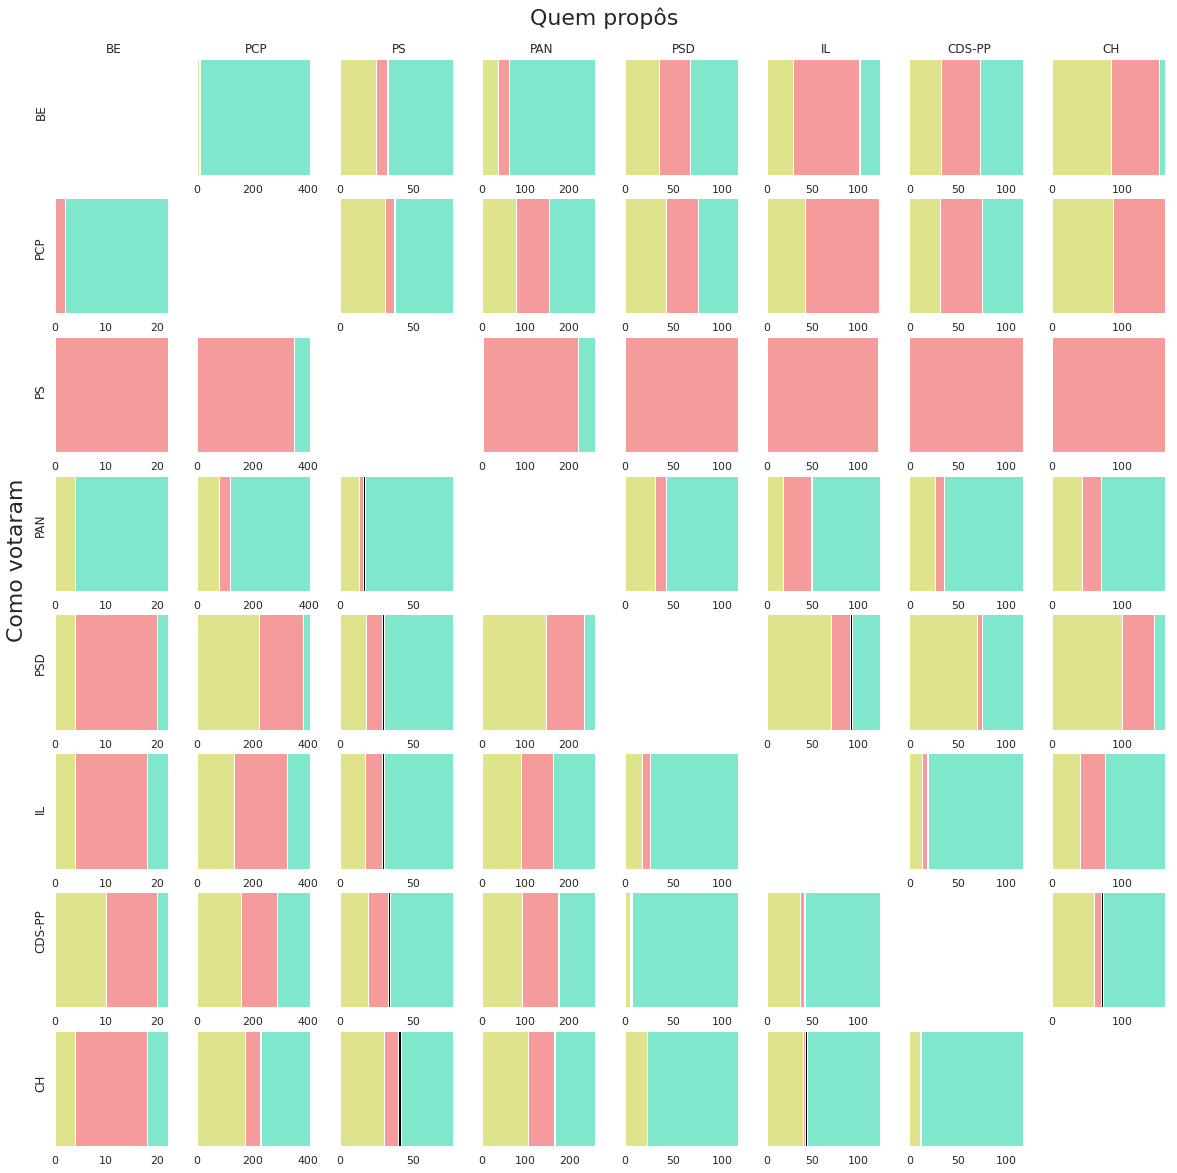

In [17]:
parties   = ['BE', 'PCP','PS', 'PAN','PSD','IL','CDS-PP', 'CH']
gpsubs = submissions_ini

cmap=ListedColormap(sns.color_palette("pastel").as_hex())
colors=["#DFE38C","#F59B9B","black","#7FE7CC" ]
cmap = ListedColormap(colors)

spn = 0
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(20, 20))
axes = axes.ravel()
for party in parties:
    for p2 in parties:
        sns.set_style("white")
        subp = gpsubs[gpsubs['GP'] == p2][[party]]
        sp = subp.fillna("Ausência").apply(pd.Series.value_counts)
        d = pd.DataFrame(columns=["GP","Abstenção", "Contra", "Ausência","Favor"]).merge(sp.T, how="right").fillna(0)
        d["GP"] = party
        d = d.set_index("GP")
        d = d[["Abstenção", "Contra", "Ausência","Favor"]]
        if p2 != party:
            sns.despine(left=True, bottom=True)
            if spn < 8:
                d.plot(kind='barh', stacked=True,width=400,colormap=cmap, title=p2,use_index=False,ax=axes[spn])
            else:
                d.plot(kind='barh', stacked=True,width=400,colormap=cmap,use_index=False,ax=axes[spn])
            axes[spn].get_legend().remove()
            plt.ylim(-4.5, axes[spn].get_yticks()[-1] + 0.5)
        else:
            axes[spn].set_xticks([])
            #d.plot(kind='barh', stacked=True,width=400,colormap=cmap,use_index=False,ax=axes[spn])
            #axes[spn].get_legend().remove()
            if spn < 8:
                axes[spn].set_title(p2)
        axes[spn].set_yticks([])
        ## Why? Who knows? Certainly not me. This is likely a side-effect of using a single axis through .ravel
        if spn%8 == 0:
            if spn != 0:
                text = axes[spn].text(-4,0,party,rotation=90)
            else:
                text = axes[spn].text(-0.17,0.5,party,rotation=90)
        #print(party, p2)
        #print(d)
        #print("-------------------------_")
        spn += 1

#axes[11].set_axis_off()
text = axes[0].text(4,1.3,"Quem propôs",rotation=0,fontsize=22)
text = axes[0].text(-0.4,-4,"Como votaram",rotation=90,fontsize=22)

#fig.tight_layout()
plt.show()

Uma outra visualização, menos condensada mas com maior clareza quantitativa: para cada partido é criado um gráfico de barras, ordenado pelos votos favoráveis, com  comportamento de votos dos restantes para com as suas propostas.

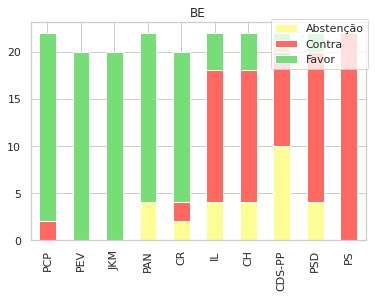

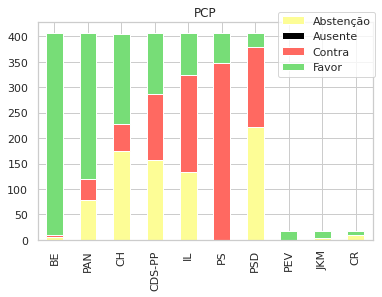

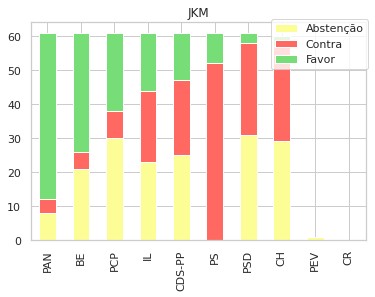

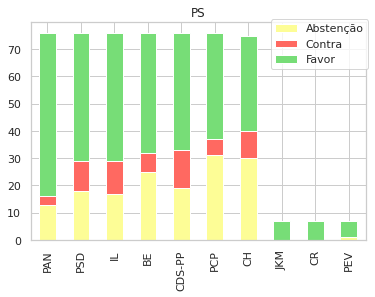

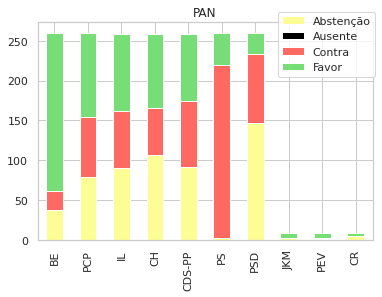

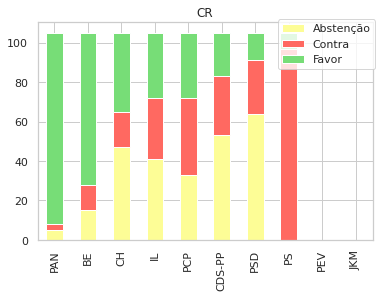

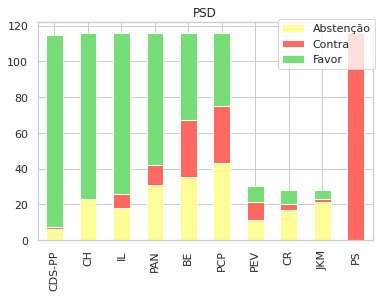

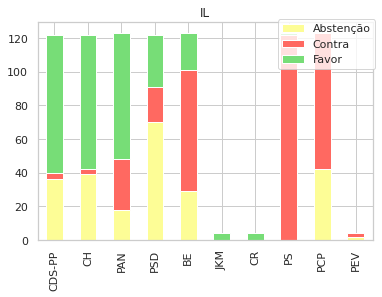

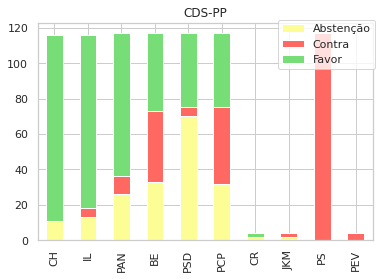

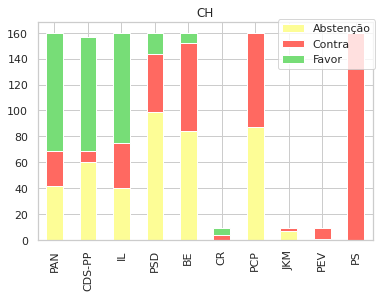

In [18]:
from IPython.display import display
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib import cm
parties   = ['BE', 'PCP', 'PEV', 'JKM','PS', 'PAN', 'CR','PSD','IL','CDS-PP', 'CH']

ndf = pd.DataFrame()
#submissions_ini_nu = submissions_ini.loc[submissions_ini['unanime'] != "unanime"]
gpsubs = submissions_ini
cmap=ListedColormap(sns.color_palette("pastel").as_hex())
colors=["#fdfd96",  "black","#ff6961","#77dd77", ]
cmap = ListedColormap(colors)

#spn = 0
#axes = axes.ravel()

for party in parties:
    sns.set_style("whitegrid")
    subp = gpsubs[gpsubs['GP'] == party]
    sp = subp[parties].apply(pd.Series.value_counts).fillna(0).drop([party],axis=1)
    sp = sp.sort_values(by=['Favor','Abstenção','Contra'], ascending=False, axis=1)
    d = sp.T
    f = plt.figure()
    plt.title(party)
    d.plot(kind='bar', ax=f.gca(), stacked=True, title=party, colormap=cmap,)
    plt.legend(loc='center left',  bbox_to_anchor=(0.7, 0.9),)
    plt.show()

plt.show()

## Dendograma e distância

Com base nas votações obtemos a distância euclideana entre todos os partidos (a distância entre todos os pares possíveis, considerado todas as votações), e com base nela um dendograma que indica a distância entre eles; note-se pelos diagramas acima que o número de votações de PEV. JKM e CR são várias ordens de magnitude inferiores aos restantes. A opção aqui foi removermos estes partidos da análise por considerarmos que o resultado seria muito pouco representativo (e possivelmente enganador) - em todo o caso, é uma opção subjectiva.

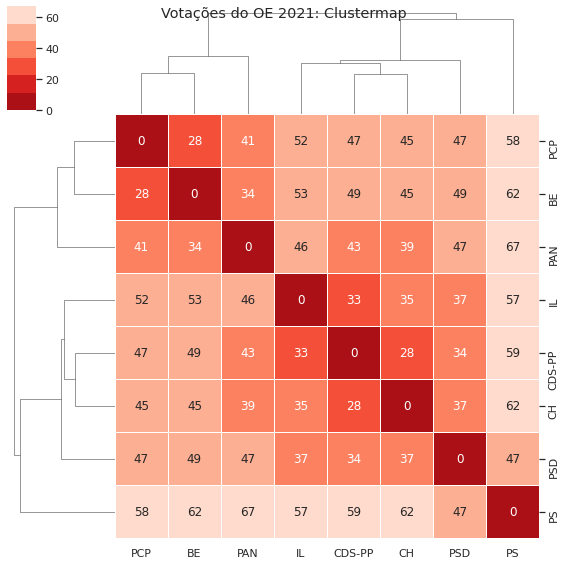

In [19]:
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
import numpy as np
votes_hm = oe_dfr[['BE', 'PCP' , 'PS', 'PAN', 'PSD','IL','CDS-PP', 'CH']]
votes_hmn = votes_hm.replace(["Favor", "Contra", "Abstenção", "Ausente"], [1,-1,0,0]).fillna(0)

## Transpose the dataframe used for the heatmap
votes_t = votes_hmn.transpose()

## Determine the Eucledian pairwise distance
## ("euclidean" is actually the default option)
pwdist = pdist(votes_t, metric='euclidean')

## Create a square dataframe with the pairwise distances: the distance matrix
distmat = pd.DataFrame(
    squareform(pwdist), # pass a symmetric distance matrix
    columns = votes_t.index,
    index = votes_t.index
)

## Normalise by scaling between 0-1, using dataframe max value to keep the symmetry.
## This is essentially a cosmetic step to 

distmat_mm=((distmat-distmat.min().min())/(distmat.max().max()-distmat.min().min()))*1

## Affinity matrix
affinmat_mm = pd.DataFrame(1-distmat_mm, distmat.index, distmat.columns)

#pd.DataFrame(distmat_mm, distmat.index, distmat.columns)
## Perform hierarchical linkage on the distance matrix using Ward's method.
distmat_link = hc.linkage(pwdist, method="ward", optimal_ordering=True )

sns.clustermap(
    distmat,
    annot = True,
    cmap=sns.color_palette("Reds_r"),
    linewidth=1,
    #standard_scale=1,
    row_linkage=distmat_link,
    col_linkage=distmat_link,
    figsize=(8,8)).fig.suptitle('Votações do OE 2021: Clustermap')

plt.show()

## MDS: *Multidimensional scaling*

Tendo como base os votos no OE podemos utilizar a mesma técnica que empregámos na análise de toda a legislatura. Para identificar grupos usamos (mais uma vez, como no trabalho original, e presente nos Apêndices) *Spectral scaling*, definindo 4 grupos.

```{margin} Votações por tema

Com base na identificação do "Tema" (_Domain_, no _dataframe_) pode-se verificar a proximidade (e _clustering_) em termos de cada tema; é necessário ter em conta a diferença (por vezes substancial) do número de votações de cada tema: existem temas com menos de 10 votações, e até com 1, o que produziria um número elevado de diagramas, razão pela qual excluímos os temas com menos de 10 votações.
```

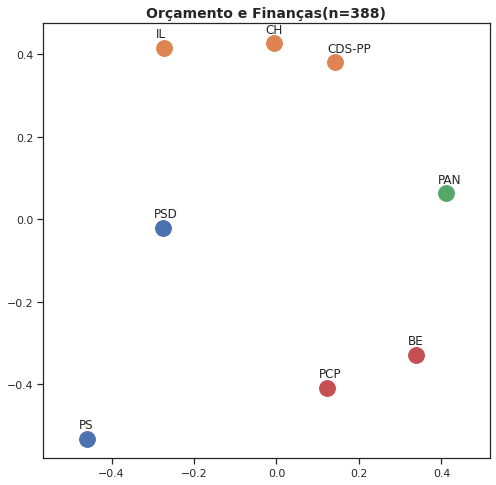

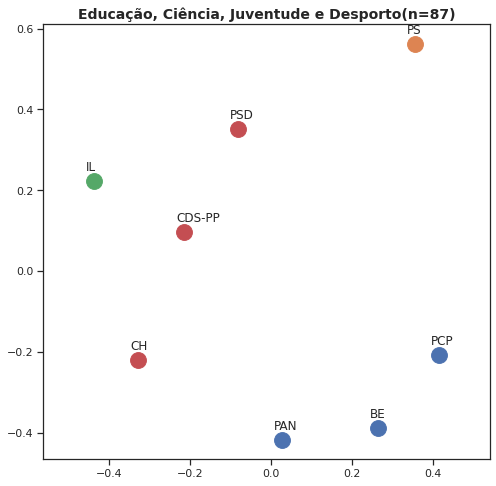

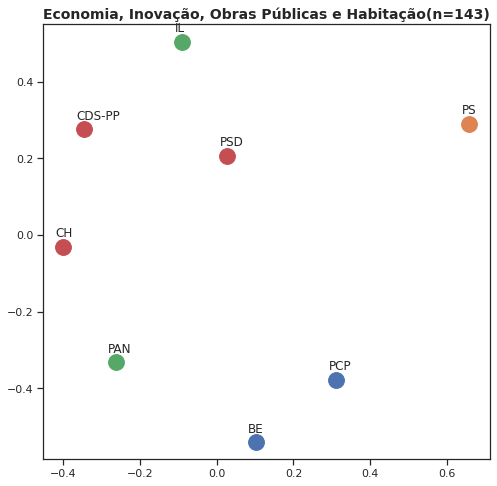

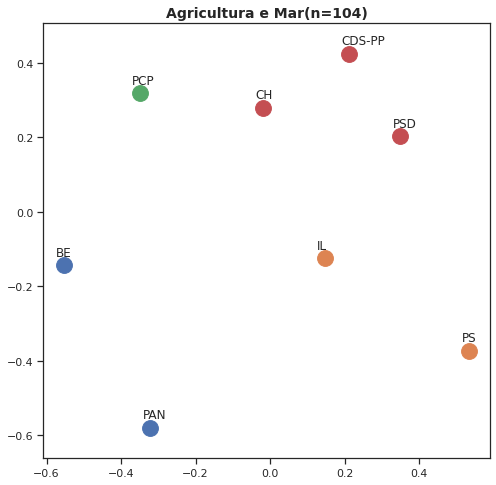

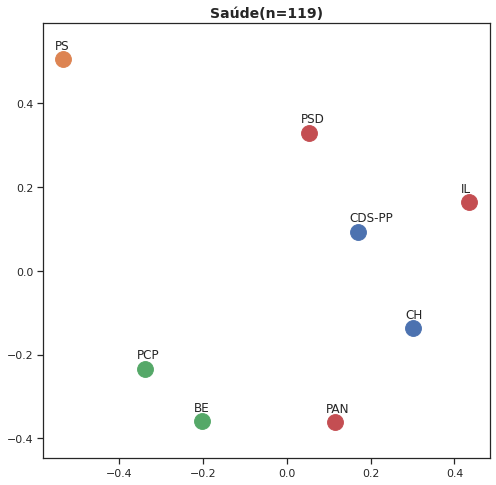

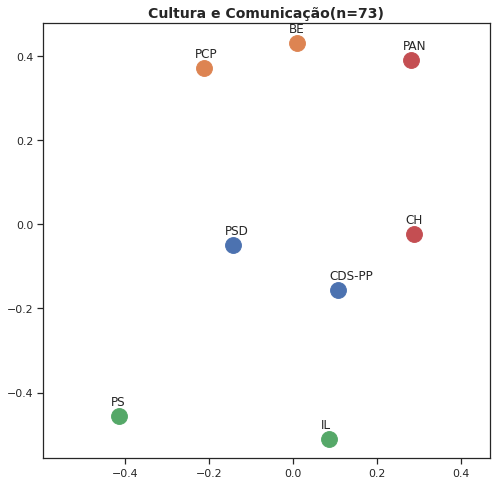

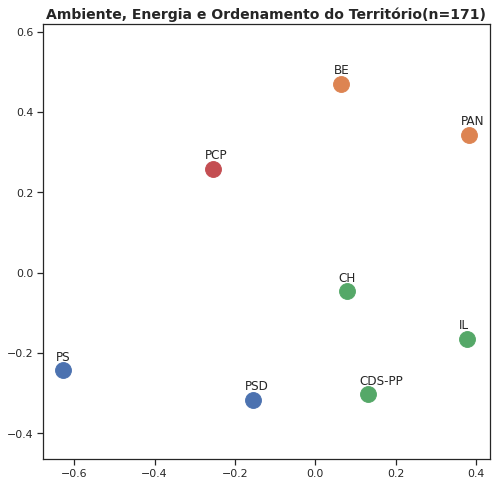

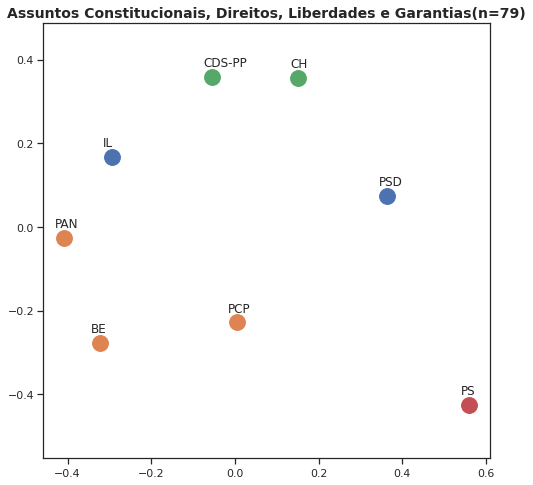

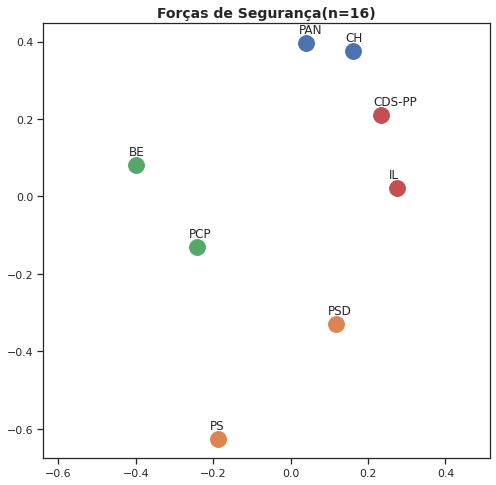

In [20]:

for area in oe_df["Domain"].unique():
    varea=oe_dfr[oe_dfr["Domain"] == area]

    avotes_hm = varea[['BE', 'PCP' , 'PS', 'PAN', 'PSD','IL','CDS-PP','CH']]
    avotes_hmn = avotes_hm.replace(["Favor", "Contra", "Abstenção", "Ausente"], [1,-1,0,0]).fillna(0) 
    if avotes_hmn.shape[0] < 10:
        continue
    avotes_t = avotes_hmn.transpose()
    apwdist = pdist(avotes_t, metric='euclidean')
    
    adistmat = pd.DataFrame(
        squareform(apwdist), # pass a symmetric distance matrix
        columns = avotes_t.index,
        index = avotes_t.index)
    adistmat_mm=((adistmat-adistmat.min().min())/(adistmat.max().max()-adistmat.min().min()))*1
    
    aaffinmat_mm = pd.DataFrame(1-adistmat_mm, adistmat.index, adistmat.columns)

    asc = SpectralClustering(4, affinity="precomputed",random_state=2020).fit_predict(aaffinmat_mm)
    asc_dict = dict(zip(adistmat,asc))   
    
    amds = MDS(n_components=2, dissimilarity='precomputed',random_state=2020, n_init=100, max_iter=1000)
    aresults = amds.fit(adistmat_mm.values)
    acoords = aresults.embedding_
    
    sns.set()
    sns.set_style("ticks")

    fig, ax = plt.subplots(figsize=(8,8))

    plt.title(area + "(n=" + str(avotes_hmn.shape[0]) +  ")", fontsize=14, fontweight="bold")

    for label, x, y in zip(adistmat_mm.columns, acoords[:, 0], acoords[:, 1]):
        ax.scatter(x, y, c = "C"+str(asc_dict[label]), s=250)
        #ax.scatter(x, y, s=250)
        ax.axis('equal')
        ax.annotate(label,xy = (x-0.02, y+0.025))
    plt.show()
    #print(asc_dict)

In [21]:
sc = SpectralClustering(3, affinity="precomputed",random_state=2020).fit_predict(affinmat_mm)
sc_dict = dict(zip(distmat,sc))

pd.DataFrame.from_dict(sc_dict, orient='index', columns=["Group"]).T

BE  PCP  PS  PAN  PSD  IL  CDS-PP  CH
Group   0    0   2    0    1   1       1   1

O resultado aparente resultar numa divisão "esquerda/centro/direita", com o PS numa posição individual; tal como referido não será indiferente o facto do PS ser o partido que suporta o Governo.

Esta separação pode ser vista também em termos de agrupamento e proximidade relativa:

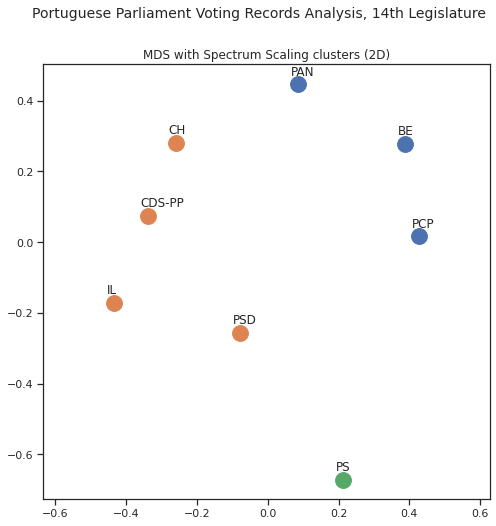

In [22]:
from sklearn.manifold import MDS
import random
mds = MDS(n_components=2, dissimilarity='precomputed',random_state=2020, n_init=100, max_iter=1000)

## We use the normalised distance matrix but results would
## be similar with the original one, just with a different scale/axis
results = mds.fit(distmat_mm.values)
coords = results.embedding_

sns.set()
sns.set_style("ticks")

fig, ax = plt.subplots(figsize=(8,8))
fig.suptitle('Portuguese Parliament Voting Records Analysis, 14th Legislature', fontsize=14)
ax.set_title('MDS with Spectrum Scaling clusters (2D)')


for label, x, y in zip(distmat_mm.columns, coords[:, 0], coords[:, 1]):
    ax.scatter(x, y, c = "C"+str(sc_dict[label]), s=250)
    ax.axis('equal')
    ax.annotate(label,xy = (x-0.02, y+0.025))

plt.show()

O resultado aqui quase mapeia a viabilização do OE: o PS enquanto partido de suporte ao Governo, os partidos à sua direita e os à sua esquerda - e o "quase" é exactamente aqui, visto o BE ter votado de forma próxima, nas votações individuais, a partidos que viabilizaram o OE, sem no entanto o ter feito.

Uma visualização em 3D adiciona uma dimensão 

In [23]:
mds = MDS(n_components=3, dissimilarity='precomputed',random_state=1234, n_init=100, max_iter=1000)
results = mds.fit(distmat.values)
parties = distmat.columns
coords = results.embedding_
import plotly.graph_objects as go
# Create figure
fig = go.Figure()

# Loop df columns and plot columns to the figure
for label, x, y, z in zip(parties, coords[:, 0], coords[:, 1], coords[:, 2]):
    fig.add_trace(go.Scatter3d(x=[x], y=[y], z=[z],
                        text=label,
                        textposition="top center",
                        mode='markers+text', # 'lines' or 'markers'
                        name=label))
fig.update_layout(
    width = 700,
    height = 700,
    title = "OE 2021: 3D MDS",
    template="plotly_white",
    showlegend=False
)
fig.update_yaxes(
    scaleanchor = "x",
    scaleratio = 1,
  )
plot(fig, filename = 'oe_3d_mds.html')
display(HTML('oe_3d_mds.html'))

## Palavras finais

Esta análise demonstra como a utilização de dados abertos pode, uma vez mais, facilitar a análise da actividade parlamentar por parte dos eleitores; as ilações políticas que se podem tirar são variadas e, se é verdade que existem limitações várias a ter em conta, tal como no trabalho relativo à análise das votações parlamentares parecem emergir padrões que parecem reflectir tendências e agrupamentos que estão presentes no discurso político.